# DESI PV Y3 TFR Calibration - Ian Williams's BGS Y3 Group Catalog

Using the list of galaxy groups defined by Ian Williams in `/global/cfs/cdirs/desi/users/ianw89/groupcatalogs/BGS_Y3/WIP`, identify DESI observations with measurements suitable for calibrating the Tully-Fisher relation. 

Export the SGA IDs of the TFR galaxies in order to later apply a multi-group joint fit to calibrate the TFR at $0.4R_{26}$.

Version: **15 April 2025** 

**Note:** This requires using a subclassed version of `hyperfit`.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 clusters, so we need to change from the default color map so that they are all plotted with different colors
from cycler import cycler
tfcolor = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667), 
(0.8509803921568627, 0.37254901960784315, 0.00784313725490196), 
(0.4588235294117647, 0.4392156862745098, 0.7019607843137254), 
(0.9058823529411765, 0.1607843137254902, 0.5411764705882353), 
(0.4, 0.6509803921568628, 0.11764705882352941), 
(0.4, 0.4, 0.4),
(0.,         0.21960784, 0.89019608),
(0.99607843, 0.74901961, 0.35294118),
(0.,         0.33333333, 0.83333333),
(9.29490e-02, 5.99040e-02, 2.39164e-01),
(0.99394079, 0.61894656, 0.26383699),
(8.04752e-01, 2.49911e-01, 4.42102e-01),
(0.,         0.66666667, 0.66666667),
(0.85396386, 0.07717032, 0.11933872),
(9.44006e-01, 3.77643e-01, 3.65136e-01),
(0.,         0.78039216, 0.60980392),
(9.92196e-01, 5.87502e-01, 4.06299e-01),
(0.50196078, 0., 0.14901961),
(0.,         0.55686275, 0.72156863),
(0.71209535, 0., 0.14901961),
(0.99703191, 0.87004998, 0.50279123),
(2.65447e-01, 6.02370e-02, 4.61840e-01),
(0.9019607843137255, 0.6705882352941176, 0.00784313725490196), 
(0.95555556, 0.2379085, 0.14640523),
(4.45163e-01, 1.22724e-01, 5.06901e-01),
(9.96369e-01, 7.91167e-01, 5.53499e-01),
(0.,         0.44313725, 0.77843137)]

plt.rcParams['axes.prop_cycle'] = cycler('color', tfcolor)

import ligo.skymap.plot

from astropy.table import Table, QTable, vstack, join
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
sys.path.insert(1, '/global/homes/m/mjkeller/DESI_SGA/TF')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust

In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')
h = 1.
H0 = 100*h
q0 = 0.2

# Access SGA Jura Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [3]:
sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y3'
# sgapath = '.'
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_jura_Vrot_VI.fits')

sgatab = Table.read(sgafits)
print(len(sgatab), 'total SGA galaxies')
sgatab[:5]

35678 total SGA galaxies


SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,PHOTSYS,V_0p4R26,V_0p4R26_err
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,bytes1,float64,float64
20,SGA-2020 20,SDSSJ173412.71+572041.6,3331584,263.5529355,57.34490699999999,S?,152.58,0.4487454,0.5333349,0.08364453,24.92448,18.036,False,LEDA-20181114,5,SDSSJ173412.71+572041.6,1,True,263.5529355,57.34490699999999,0.4487454,2635p572,263.55294849855886,57.344862145664294,0.4460123,SB26,152.3756,0.5778338,263.5528114673963,57.34481025685253,10.459747,5.9780583,5.751067,4.821581,1.4858595,3.4448266,5.1149526,6.748707,8.426254,9.720271,11.022999,12.0887985,13.380368,20.656942,20.044735,19.40886,19.194794,18.66572,18.231262,18.599888,18.123905,17.745926,18.256256,17.807074,17.476473,18.040592,17.60353,17.319197,17.926336,17.500519,17.228865,17.85259,17.42695,17.180876,17.811844,17.39206,17.151228,17.783718,17.36542,17.143204,0.02069058,0.026094317,0.03480586,0.05076174,0.08751116,0.10309491,0.08337893,0.10982923,0.13734566,0.031223593,0.046367057,0.0777883,0.015935475,0.020728666,0.032657374,0.012760426,0.014699919,0.022893604,0.010505663,0.011998588,0.018923525,0.010358521,0.011374098,0.017719442,0.010557283,0.0112259,0.017149422,0.010553381,0.011049819,0.017135512,0.010413324,0.010993488,0.01699026,0.010291049,0.010862263,0.017057167,17.6411,0.6362121,0.53480667,2.8045392,1.7123051,17.22401,0.6144014,0.53440714,2.7180903,2.1161501,17.062769,0.44818503,0.43006793,3.1755726,0.97457016,0,0.08361389105924856,2.4100568709106263e-05,N,147.82237894320167,8.33731363315019
32,SGA-2020 32,PGC26

# Load Morphological Classification using the SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query; Largett et al., in prep.). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [4]:
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
# ai_morphpath = '.'
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
# ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')
# ai_morphcsv = os.path.join(ai_morphpath, 'TFY3_Classification.csv')

ai_morphcsv = '/global/homes/m/mjkeller/DESI_SGA/TF/Y3/SGAY3TFMorphologies.csv'

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab[:5]

SGA_ID,Predicted_Type_spiral,Predicted_Type_elliptical,Predicted_Type_irregular,Predicted_Type_lenticular,Predicted_Type
float64,str6,str10,str9,str10,str10
218203.0,Other,Other,Irregular,Other,Irregular
218205.0,Other,Other,Irregular,Other,Irregular
218239.0,Other,Other,Irregular,Other,Irregular
218275.0,Other,Other,Irregular,Other,Irregular
218304.0,Spiral,Other,Other,Other,Spiral


In [5]:
sum(ai_morphtab['Predicted_Type_spiral'] == 'Spiral') + sum(ai_morphtab['Predicted_Type_elliptical'] == 'Elliptical') + sum(ai_morphtab['Predicted_Type_lenticular'] == 'Lenticular') + sum(ai_morphtab['Predicted_Type_irregular'] == 'Irregular')

33995

Cool, so Julia gave us a table with only those objects with certain classifications from all three binary classifiers.  Therefore, if `Spiral_Pred` = 'Spiral', then this is a spiral galaxy.

In [6]:
'''
# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

for i in tqdm(range(len(ai_morphtab))):
    
    classes = ai_morphtab['Predicted_Type_spiral', 'Predicted_Type_elliptical', 'Predicted_Type_lenticular', 'Predicted_Type_irregular'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')''';

# Combine ML morphtypes with SGA catalog

In [7]:
'''
#- Match SGA_ID in the two tables and return index into ai_morphtab
idx = np.where(ai_morphtab['SGA_ID'][:, None] == sgatab['SGA_ID'][None, :])[1]

#- Create a new column in the SGA table
sgatab['MORPHTYPE_AI'] = ai_morphtab['Predicted_Type'][idx]
''';

sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection
* $i > 45^\circ$
* Spiral-type morphology

The first three items have already been applied.

In [8]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max

#- Morphology cut: spiral, not S0
is_good_morph = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    try:
        if (sgatab['MORPHTYPE'][i][0] == 'S' and sgatab['MORPHTYPE'][i][:2] != 'S0') or (sgatab['MORPHTYPE_AI'][i][0] == 'S'):
            is_good_morph[i] = True
    except IndexError as e:
        continue
        
#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- Combine selections:
# is_good_sga = is_good_incl & is_good_morph
is_good_sga = is_good_incl & is_good_morph_ML

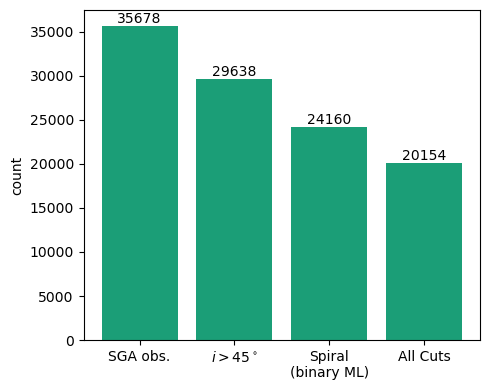

In [9]:
data = {
    'SGA obs.' : len(sgatab),
    # r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(5,4), tight_layout=True)
bars = ax.bar(names, values)
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y3/TF_Y3_SGA_Vrot_cuts.png', dpi=150, facecolor='none');

# Photometric corrections

### Survey offsets

In [10]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### Dust corrections

In [11]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [12]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/global/homes/m/mjkeller/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [13]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [14]:
# Apparently we have some galaxies with negative redshifts
zg0 = sgatab['Z_DESI'] >= 0

In [15]:
kcorr_zg0 = k_corr(sgatab['Z_DESI'][zg0], 
                   [sgatab['G_MAG_SB26'][zg0], sgatab['R_MAG_SB26'][zg0], sgatab['Z_MAG_SB26'][zg0]], 
                   [sgatab['G_MAG_SB26_ERR'][zg0], sgatab['R_MAG_SB26_ERR'][zg0], sgatab['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # K-correcting to same redshift as FastSpecFit (which is what Caitlin's using for the FP)

In [16]:
kcorr = np.zeros([len(sgatab), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$. 

In [17]:
temp_infile = open('/global/homes/m/mjkeller/DESI_SGA/TF/Y3/jura_internalDust_mcmc.pickle', 'rb')
dust_mcmc_samples,_ = pickle.load(temp_infile)
temp_infile.close()

In [18]:
internalDust_coeffs = np.median(dust_mcmc_samples, axis=1)

internalDust_coeffs_err = np.zeros(len(internalDust_coeffs))
internalDust_coeffs_err[0] = np.std(dust_mcmc_samples[0][(-1.5 < dust_mcmc_samples[0]) & (dust_mcmc_samples[0] < 0)])
internalDust_coeffs_err[1] = np.std(dust_mcmc_samples[1][(0 < dust_mcmc_samples[1]) & (dust_mcmc_samples[1] < 1)])

In [19]:
internalDust_corr, internalDust_corr_err = internal_dust(sgatab['BA'], 
                                                         internalDust_coeffs, 
                                                         internalDust_coeffs_err)

## Apply corrections

In [20]:
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr

In [21]:
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err**2)

## Load SN Ia Calibrators for the TFR Zero Point

List of SNe Ia from UNION3 and Pantheon+ from Anthony Carr. Match these to the SGA Jura observations that have passed all quality cuts.

In [22]:
# zeroptpath = '../cache/'
# zeroptpath = '.'
zeroptab = Table.read('/global/homes/m/mjkeller/DESI_SGA/TF/SGA-2020_jura_Vrot_0pt_calib.fits')

In [23]:
#- Extract the 0-point SNe Ia that match SGA IDs in the good catalog (passed all rotation curve cuts).
#  Merge the tables so we can use the zero point later.
idx = np.in1d(zeroptab['SGA_ID'], sgatab['SGA_ID'][is_good_sga])
# zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx]

zeroptab = join(sgatab, zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx], keys='SGA_ID')

#- Write catalog to file
zeroptab.write('SGA_distances_0pt_iron_z0p1.fits', overwrite=True)
zeroptab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,PHOTSYS,V_0p4R26,V_0p4R26_err,MORPHTYPE_AI,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,MU_PRIMARY,MU_SECONDARY,MU_ERR,MU_SOURCE
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,bytes1,float64,float64,str10,float64,float64,float64,float64,float64,bytes22
103123.0,SGA-2020 103123,SDSSJ074708.56+275429.4,4145061,116.785734,27.9081857,Sm,104.01,0.38282475,0.46344694,0.027839927,24.05848,17.515,False,LEDA-20181114,36629,SDSSJ074708.56+275429.4,1,True,116.785734,27.9081857,0.38282475,1168p280,116.78564045230306,27.908157346916912,0.5242874,SB26,105.55979,0.42825085,116.78555987055356,27.908243085963594,10.796608,5.006394,4.9300413,5.0233784,5.3875837,6.9426413,8.216747,9.404112,10.399142,11.295491,12.742218,14.235971,15.7286215,17.604733,17.260372,17.05073,17.319956,16.985378,16.785225,17.163937,16.835436,16.642214,17.066725,16.745531,16.559727,17.013998,16.69732,16.512413,16.98692,16.672842,16.485397,16.96346,16.646526,16.452162,16.950823,16.63161,16.42804,16.94372,16.621382,16.413736,0.119631045,0.13098262,0.124674216,0.08537393,0.14872828,0.10716611,0.19776088,0.30018482,0.19377819,0.051805183,0.0524946,0.052369807,0.047844343,0.048005756,0.048017472,0.04475182,0.044847436,0.04496339,0.04237442,0.042545233,0.042796962,0.04089616,0.04112096,0.04145352,0.040052317,0.04035627,0.040580835,0.039257288,0.039455555,0.039491918,0.038829774,0.038951498,0.038718507,0.038588796,0.03860099,0.038273342,16.937357,0.18874116,0.66011643,6.336392,0.006876157,16.612106,0.22721396,0.5772447,5.4077415,0.007939731

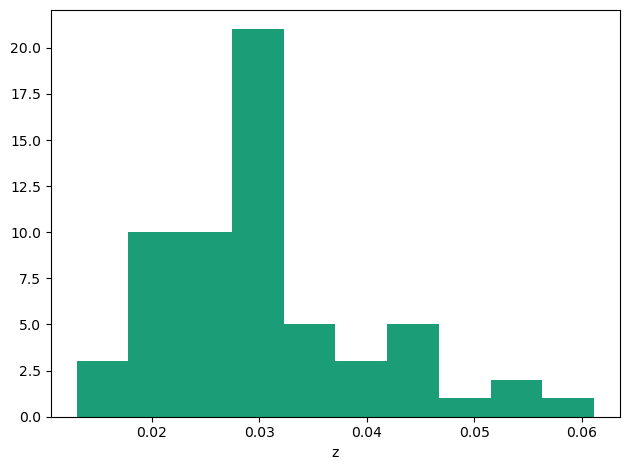

In [24]:
plt.figure(tight_layout=True)

plt.hist(zeroptab['Z_DESI'])

plt.xlabel('z');

In [25]:
# Only keep galaxies with a primary SN match
# zeroptab = zeroptab[~zeroptab['MU_PRIMARY'].mask]

In [26]:
np.unique(zeroptab['MU_SOURCE'], return_counts=True)

(<Column name='MU_SOURCE' dtype='bytes22' length=32>
        1999cc
        2000dg
        2001cj
        2001da
        2001ep
        2004bk
        2005hc
        2006az
        2006bt
        2006bw
        2006cq
        2007ba
           ...
 2013gy+2009kk
        2014ai
   ASASSN-15nr
   ASASSN-16ct
     AT2016bln
     AT2017cfc
       PS15aii
       PS16axi
       PS16ayd
       PS16bnz
        PS16fa
     SN2017ckx,
 array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  3,  2,  1,  1, 19,  1,
         4,  3,  1,  1,  1,  1,  1,  1,  2,  1,  2,  2,  1,  1,  1]))

### Plot the Zero Point Calibrators

Sky coordinates of the SNe with good DESI rotational velocities.

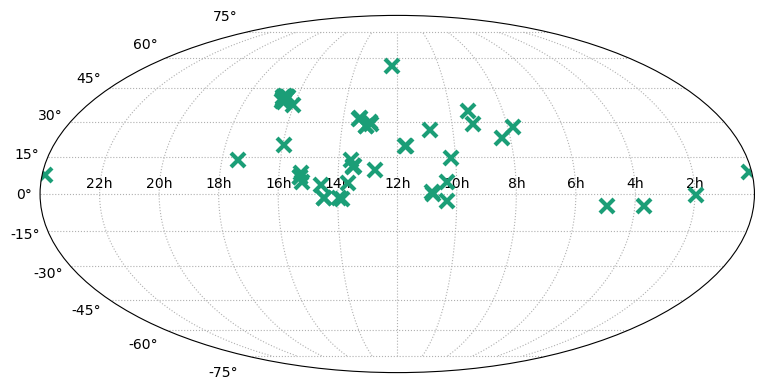

In [27]:
sne_coords = SkyCoord(ra=zeroptab['RA'], dec=zeroptab['DEC'], frame='icrs', unit='deg')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
_ra = np.radians(180*u.deg - sne_coords.ra)
_dec = np.radians(sne_coords.dec)
ax.plot(_ra, _dec, 'x', ms=10, mew=3)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/code/desiutil/main/py/desiutil/plots.py:454: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  paths = ax.scatter(projection_ra(0, galactic.ra.degree),
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/code/desiutil/main/py/desiutil/plots.py:471: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  paths = ax.scatter(projection_ra(0, ecliptic.ra.degree),


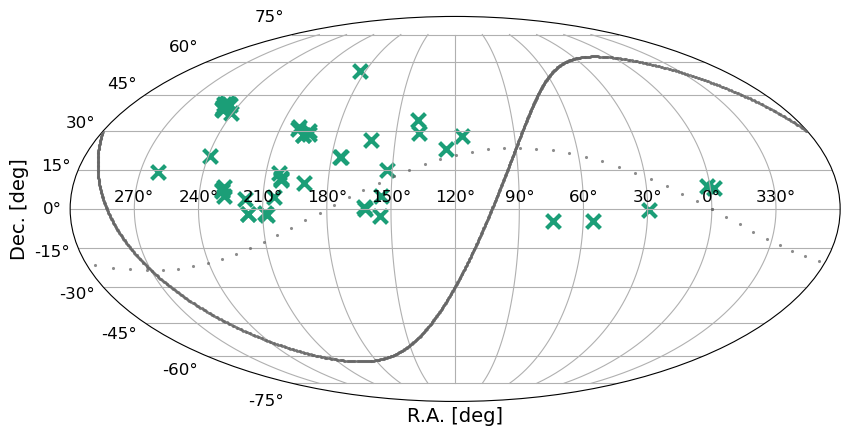

In [28]:
colors = plt.get_cmap('Dark2').colors
ax = init_sky(galactic_plane_color = colors[7], ecliptic_plane_color = colors[7])

ax.scatter(ax.projection_ra(sne_coords.ra.value), 
           ax.projection_dec(sne_coords.dec.value), 
           marker='x', 
           s=100,
           linewidth=3,
           color = colors[0])

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig('../../Figures/Y1/iron_0pt_sky.png', dpi=150, facecolor='none');

### Compute the Absolute Magnitude of the 0-pt Calibrators based on the Distance

Compute the absolute magnitude
$$
M_r - 5\log{h} = m_r - \mu - 5\log{h},
$$
where $h$ is the reduced Hubble constant used to calibrate the distance modulus $\mu$.

Since our calibrators are from Pantheon+SH0ES, where distances are based on the distance ladder, there is no assumed value of $h$.

In [29]:
#- Clean up the distance modulus
use_primary = zeroptab['MU_SECONDARY'] < 0
mu = zeroptab['MU_SECONDARY']
mu[use_primary] = zeroptab['MU_PRIMARY'][use_primary]
# mu = zeroptab['MU_PRIMARY']

#- Compute the absolute magnitude
zeroptab['R_ABSMAG_SB26'] = zeroptab['R_MAG_SB26_CORR'] - mu
zeroptab['R_ABSMAG_SB26_err'] = np.sqrt(zeroptab['R_MAG_SB26_ERR_CORR']**2 + zeroptab['MU_ERR']**2)

In [30]:
# Save this table
zeroptab.write('SGA-2020_jura_Vrot_VI_0pt_calib_z0p1.fits', overwrite=True)

# Access Group Catalog

These groups come from the group catalog being created by Ian Williams `/global/cfs/cdirs/desi/users/ianw89/groupcatalogs/BGS_Y3/WIP`, still a work in progress as of April 2025. 

Membership is defined in the catalog, and does not need to be re-calculated in the notebook. See Ian's README for further information. 

In [31]:
# group table from Ian Williams.

groups = Table.read('/global/cfs/cdirs/desi/users/ianw89/groupcatalogs/BGS_Y3/WIP/GROUP_CATALOG_BGS_Y3_vWIP.fits')
print(len(groups), 'galaxies')
groups[:10]

7294015 galaxies


TARGETID,RA,DEC,Z,L_GAL,VMAX,P_SAT,M_HALO,N_SAT,L_TOT,IGRP,WEIGHT,APP_MAG_R,Z_ASSIGNED_FLAG,G_R,IS_SAT,QUIESCENT,MSTAR
,deg,deg,,solLum,Mpc3,,solMass,,solLum,,,,,,,,solMass
int64,float64,float64,float64,float64,float64,float64,float64,int32,float64,int64,float64,float64,int32,float64,bool,bool,float64
39627351755068123,49.834953,-18.154497,0.223119,9910589000.0,2381290000.0,0.0,3364188000000.0,0,9910589000.0,0,1.0,19.01287078857422,8,0.4727267266895794,False,False,--
39627351755069619,49.884101,-18.144277,0.077145,23113710000.0,2381290000.0,0.0,7576602000000.0,1,25390040000.0,1,1.0,15.423483848571777,0,0.9535473819308038,False,True,81316050547.84206
39627351755069935,49.893713,-18.130689,0.233269,11987900000.0,2381290000.0,0.0,3789875000000.0,0,11987900000.0,2,1.0,19.000844955444336,0,0.809559315295477,False,True,--
39627351759257696,49.928422,-18.144042,0.233045,10453490000.0,2381290000.0,0.0,5921318000000.0,1,20394420000.0,3,1.0,19.1475772857666,1,0.9369175805413477,False,True,--
39627351759257779,49.930442,-18.146842,0.233045,9940930000.0,2381290000.0,0.963666,5921318000000.0,1,20394420000.0,3,1.0,19.071929931640625,0,0.33665296436558734,True,False,--
39627351759259088,49.974063,-18.144339,0.221473,18031390000.0,2381290000.0,0.0,5242426000000.0,0,18031390000.0,5,1.0,18.40841293334961,0,0.9636422657531298,False,True,61875699083.755455
39627351759259125,49.975248,-18.208203,0.077615,3384922000.0,2381290000.0,0.396964,2314911000000.0,0,3384922000.0,6,1.0,17.548555374145508,0,0.5530821412133982,False,False,--
39627351759259224,49.978789,-18.164512,0.241574,8494190000.0,2381290000.0,0.0,3100359000000.0,0,8494190000.0,7,1.0,19.449382781982422,0,0.5167093426542344,False,False,39116889319.2879


In [32]:
group_ids, counts = np.unique(groups['IGRP'], return_counts = True)
print(len(group_ids), 'total groups')

5473899 total groups


In [33]:
grps_ids = np.unique(groups['IGRP'], return_counts = True)
grps_sufficient = []

# check for the number of groups with "enough" galaxies (more than 8) 
grps_plurality = np.extract(grps_ids[1]>8, grps_ids)
for i in range(len(grps_ids[0])): 
    if i in grps_plurality: 
        grps_sufficient.append(i)
print(len(grps_sufficient),'total groups >8 members')

19044 total groups >8 members


# Find SGA Galaxy Group Membership

Identify SGA galaxies in the list of galaxy groups.

In [34]:
#- Sky coordinates of SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]

sga_coords = SkyCoord(sgatab_sel['RA']*u.deg, sgatab_sel['DEC']*u.deg)
z_sga_desi = sgatab_sel['Z_DESI']
print(len(sgatab_sel), "total SGA galaxies")

20154 total SGA galaxies


In [35]:
# match between Ian's catalog and the SGA galaxies

# Sky coordinates of Ian's galaxies
grp_coords = SkyCoord(groups['RA'], groups['DEC'])

match_ids, match_dist, match_sep = sga_coords.match_to_catalog_sky(grp_coords)
print(len(match_sep), "total matching galaxies")

20154 total matching galaxies


In [36]:
sgatab_sel['IGRP'] = groups['IGRP'][match_ids]
print(len(sgatab_sel), 'total matching galaxies')
sgatab_sel[:5]

20154 total matching galaxies


SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,PHOTSYS,V_0p4R26,V_0p4R26_err,MORPHTYPE_AI,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,IGRP
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,bytes1,float64,float64,str10,float64,float64,int64
32.0,SGA-2020 32,PGC2644444,2644444,212.02461,62.8385803,Sc,26.25,0.3758374,0.60255957,0.09556411,23.73748,17.234,False,LEDA-20181114,10,PGC2644444,1,True,212.02461,62.8385803,0.3758374,2122p627,212.02462598739942,62.838526399057336,0.68802845,SB26,22.800411,0.4168182,212.02444469714254,62.83861910315144,15.352884,7.5523267,7.0574827,6.552769,6.8422165,9.006861,11.119019,13.218836,14.83576,16.089632,17.419872,18.262827,20.640854,17.682621,16.800076,16.140163,17.36588,16.500635,15.859558,17.164816,16.315928,15.683345,17.029795,16.192858,15.569851,16.956533,16.127148,15.511885,16.912262,16.09487,15.481129,16.881954,16.068357,15.467079,16.868856,16.055609,15.458797,16.854921,16.045063,15.448293,0.076427355,0.10654599,0.14980716,0.14600274,0.17229652,0.11901944,0.1291893,0.1625502,0.3402725,0.028715666,0.03028943,0.031358354,0.026863642,0.028016893,0.029046243,0.025209688,0.026244337,0.027134262,0.023817942,0.024750203,0.025650727,0.022882456,0.023803992,0.024767375,0.022301689,0.023322092,0.02424668,0.02186869,0.022889571,0.023994846,0.021672187,0.022686103,0.023837518,0.02142763,0.022476751,0.023631034,16.8146,0.23519146,5.7815895,4.999612,0.39062694,16.011211,0.2319782,4.483918,4.8892393,0.2325632,15.429928,0.18450199,5.2820787,5.672057,0.13526808,0,0.09554957288202022,3.920136884954893e-05,N,264.453733

# Separation Quality Checking

Using the same processes as in `/DESI_SGA/TF/Y1/TF_Y1_VI.ipynb` to conduct visual inspection, determine which separations should be considered "good" coordinate matches. Ultimate outcome: keep just the first bin, up to `sep`$= 0.1R_{26}$.

In [37]:
# make the separation cut as defined
sep_R26 = (2*match_sep)/sgatab_sel['D26']
VI_tab = sgatab_sel[sep_R26 <= .1]

print(len(VI_tab), 'total matching galaxies passing VI')
VI_tab[:5]

20076 total matching galaxies passing VI


SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,PHOTSYS,V_0p4R26,V_0p4R26_err,MORPHTYPE_AI,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,IGRP
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,bytes1,float64,float64,str10,float64,float64,int64
32.0,SGA-2020 32,PGC2644444,2644444,212.02461,62.8385803,Sc,26.25,0.3758374,0.60255957,0.09556411,23.73748,17.234,False,LEDA-20181114,10,PGC2644444,1,True,212.02461,62.8385803,0.3758374,2122p627,212.02462598739942,62.838526399057336,0.68802845,SB26,22.800411,0.4168182,212.02444469714254,62.83861910315144,15.352884,7.5523267,7.0574827,6.552769,6.8422165,9.006861,11.119019,13.218836,14.83576,16.089632,17.419872,18.262827,20.640854,17.682621,16.800076,16.140163,17.36588,16.500635,15.859558,17.164816,16.315928,15.683345,17.029795,16.192858,15.569851,16.956533,16.127148,15.511885,16.912262,16.09487,15.481129,16.881954,16.068357,15.467079,16.868856,16.055609,15.458797,16.854921,16.045063,15.448293,0.076427355,0.10654599,0.14980716,0.14600274,0.17229652,0.11901944,0.1291893,0.1625502,0.3402725,0.028715666,0.03028943,0.031358354,0.026863642,0.028016893,0.029046243,0.025209688,0.026244337,0.027134262,0.023817942,0.024750203,0.025650727,0.022882456,0.023803992,0.024767375,0.022301689,0.023322092,0.02424668,0.02186869,0.022889571,0.023994846,0.021672187,0.022686103,0.023837518,0.02142763,0.022476751,0.023631034,16.8146,0.23519146,5.7815895,4.999612,0.39062694,16.011211,0.2319782,4.483918,4.8892393,0.2325632,15.429928,0.18450199,5.2820787,5.672057,0.13526808,0,0.09554957288202022,3.920136884954893e-05,N,264.453733

In [38]:
# check the number of groups with different numbers of galaxies AFTER the VI cut

grp_IGRP, grp_count = np.unique(VI_tab['IGRP'], return_counts = True)
print('5+ galaxies:', np.sum(grp_count >= 5))
print('8+ galaxies:', np.sum(grp_count >= 8))
print('10+ galaxies:', np.sum(grp_count >= 10))
print('15+ galaxies:', np.sum(grp_count >= 15))

5+ galaxies: 25
8+ galaxies: 6
10+ galaxies: 4
15+ galaxies: 1


In [39]:
# keep groups with more than 8 galaxies

full_group = grp_count >= 8
grp_ids = []
for i in range(len(full_group)): 
    if full_group[i] == True: 
        grp_ids.append(grp_IGRP[i])
print(grp_ids)

[598888, 737552, 1126420, 3745522, 5072306, 5602233]


In [40]:
VI_tab.add_index('IGRP')
sgatab_sel.add_index('IGRP')

sga_groups = {}
for i in range(len(grp_ids)): 
    group = VI_tab.loc['IGRP', grp_ids[i]]
    sga_groups[grp_ids[i]] = list(group['SGA_ID'])

rej_groups = {}  
for i in range(len(grp_ids)): 
    group = sgatab_sel.loc['IGRP', grp_ids[i]]
    rej_groups[grp_ids[i]] = list(group['SGA_ID'])

In [41]:
print('-----before VI-----')
for i, (group_id, sga_ids) in enumerate(rej_groups.items()):
    print(f'{i+1:2d} {group_id:7d} {len(sga_ids):3d} galaxies')
print('------after VI-----')
for i, (group_id, sga_ids) in enumerate(sga_groups.items()):
    print(f'{i+1:2d} {group_id:7d} {len(sga_ids):3d} galaxies')

-----before VI-----
 1  598888  12 galaxies
 2  737552   9 galaxies
 3 1126420  12 galaxies
 4 3745522  13 galaxies
 5 5072306   8 galaxies
 6 5602233  27 galaxies
------after VI-----
 1  598888  12 galaxies
 2  737552   9 galaxies
 3 1126420  12 galaxies
 4 3745522  13 galaxies
 5 5072306   8 galaxies
 6 5602233  27 galaxies


## Sanity Checks: Plot Cluster Positions and Galaxy Coordinates

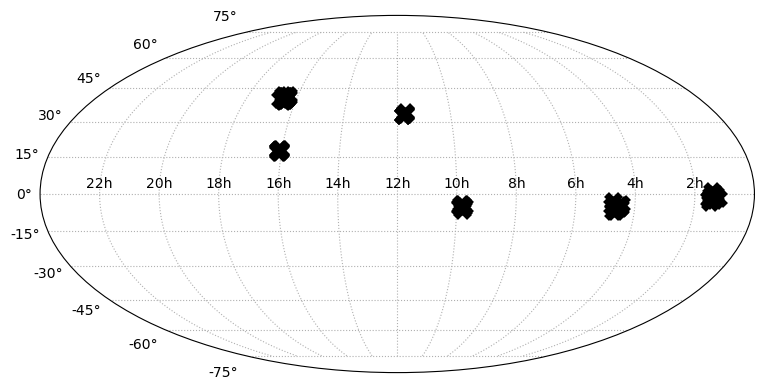

In [42]:
nest_ids = grp_ids
idx = np.in1d(VI_tab['IGRP'], nest_ids) 
grp_lon = VI_tab['RA_LEDA'][idx]
grp_lat = VI_tab['DEC_LEDA'][idx]

group_coords = SkyCoord(grp_lon, grp_lat, unit='deg')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
for coord in group_coords:
    _ra = np.radians(180*u.deg - coord.transform_to('icrs').ra)
    _dec = np.radians(coord.transform_to('icrs').dec)
    ax.plot(_ra, _dec, 'kx', ms=10, mew=5)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

In [43]:
def geometric_median(X, eps=1e-6):
    """Compute the weighted geometric median of a set of points using Weiszfeld's algorithm.

    From https://github.com/scoutant/l1-median. Weiszfeld's algorithm may fail to converge
    if a guess is located on top of one of the initial points. If that occurs, move the guess.
    
    A summary of other algorithms is provided in
    https://www.cs.cmu.edu/~./glmiller/Publications/Papers/CLMPS16.pdf.

    Parameters
    ----------
    X : ndarray
        list of sample points (n-D), given as a 2D array
    eps : float
        Tolerance for convergence to the median.

    Returns
    -------
    y : ndarray
        First n-D estimate of the median satisfying the tolerance.
    """
    #- See with the geometric mean
    y = np.mean(X,0)
    while True:
        #- Compute Euclidean distances. Move away to avoid any null distances.
        while np.any(cdist(X,[y])==0):
            y +=0.1*np.ones(len(y))
            
        #- Weights that are the inverse of the distances from current estimate to the observations
        W = 1/cdist(X,[y]) # element-wise
        
        #- Update is the weighted average of the observations
        y1 = np.sum(W*X,0)/np.sum(W) # sum along axis 0
        if euclidean(y,y1) < eps:
            return y1
        y = y1

def group_median_coords(galaxy_coords):
    """Compute the geometric median coordinate of the galaxies in a group.

    Parameters
    ----------
    galaxy_coords : ndarray
        List of SkyCoords for galaxies in a cluster or group.

    Returns
    -------
    gal_median : SkyCoord
        Coordinates of the geometric median.
    """
    #- Pack the group's coordinates into an array of Cartesian coordinates
    galcoords = []
    for galaxy in galaxy_coords:
        galcoords.append(galaxy.represent_as('cartesian').get_xyz())
    galcoords = np.asarray(galcoords)

    #- Compute the geometric median.
    gm = geometric_median(galcoords)
    lonlat = SkyCoord(x=gm[0], y=gm[1], z=gm[2], representation_type='cartesian').transform_to('icrs').represent_as('unitspherical')
    gal_median = SkyCoord(ra=lonlat.lon.deg, dec=lonlat.lat.deg, unit='degree', frame='icrs')

    return gal_median

In [44]:
def plot_group_members(grpcat1, grpcat2, grpid, sgacat, sgaid):
    '''Generate a set of diagnostic plots for the members of a cluster.'''
    colors = plt.get_cmap('Dark2').colors
    #- Handling catalog length nonsense; grpcat1 or grpcat2 may be missing galaxies, so check which is longer
    
    grp_idx1 = np.in1d(grpcat1['IGRP'], grpid)
    grp_idx2 = np.in1d(grpcat2['IGRP'], grpid)
    grpcat1_len = len(grpcat1['RA'][grp_idx1])
    grpcat2_len = len(grpcat2['RA_LEDA'][grp_idx2])
    
    # Choosing the catalog that has the larger galaxy count to run with
    if grpcat1_len > grpcat2_len: 
        grpcat = grpcat1
        grp_coord = SkyCoord(ra=grpcat['RA'][grp_idx1], dec=grpcat['DEC'][grp_idx1], unit='deg', frame='icrs')
        z_grp = grpcat['Z'][grp_idx1]
    else: 
        grpcat = grpcat2
        grp_coord = SkyCoord(ra=grpcat['RA_LEDA'][grp_idx2], dec=grpcat['DEC_LEDA'][grp_idx2], unit='deg', frame='icrs')
        z_grp = grpcat['Z_DESI'][grp_idx2]

    #- Get group median coordinates for all galaxies in the group 
    grp_idx = np.in1d(grpcat['IGRP'], grpid)
    grp_coord_med = group_median_coords(grp_coord)
    
    z_grp_sorted = np.sort(z_grp)
    ngal_grp = len(z_grp_sorted)
    z_grp_med = np.mean(z_grp_sorted[ngal_grp//2:ngal_grp//2 + 2]) if (ngal_grp % 2 == 0) else z_grp_sorted[ngal_grp//2]
    
    #- Get SGA galaxy coordinates and median of observations
    sga_idx = np.in1d(sgacat['SGA_ID'], sgaid)
    sga_coord = SkyCoord(ra=sgacat['RA_LEDA'][sga_idx], dec=sgacat['DEC_LEDA'][sga_idx], unit='deg', frame='icrs')
    sga_coord_med = group_median_coords(sga_coord)
    
    z_sga = sgacat['Z_DESI'][sga_idx]
    z_sga_sorted = np.sort(z_sga)
    ngal_sga= len(z_sga_sorted)
    z_sga_med = np.mean(z_sga_sorted[ngal_sga//2:ngal_sga//2 + 2]) if (ngal_sga % 2 == 0) else z_sga_sorted[ngal_sga//2]

    #- Calculate R2t to plot
    grp_R2t = np.max(grp_coord.separation(grp_coord_med))/3

    dz = 0.001
    delta_angle = 0.25
    ramin = np.min(grp_coord.ra.deg)
    ramax = np.max(grp_coord.ra.deg)
    decmin = np.min(grp_coord.dec.deg)
    decmax = np.max(grp_coord.dec.deg)
    zmin = np.min(np.round(z_grp, 2)) - 4*dz
    zmax = np.max(np.round(z_grp, 2)) + 4*dz

    #- Plot the angular coordinates and redshifts
    fig = plt.figure(figsize=(12,8), tight_layout=True)
    ax = plt.subplot(231, projection='astro degrees zoom', center=grp_coord_med, radius=4*grp_R2t)

    outer = SphericalCircle(grp_coord_med, 3*grp_R2t, edgecolor=colors[7], linestyle='solid', transform=ax.get_transform('world'), facecolor='none')
    ax.add_patch(outer)

    inner = SphericalCircle(grp_coord_med, 1.5*grp_R2t, edgecolor=colors[7], linestyle='dotted', transform=ax.get_transform('world'), facecolor='none')
    ax.add_patch(inner)

    ax.grid()
    
    # transform=ax.get_transform('world'),
    ax.plot(grp_coord.ra.deg, grp_coord.dec.deg, 'k.', transform=ax.get_transform('world'), alpha = .25)
    ax.plot(grp_coord_med.ra.deg, grp_coord_med.dec.deg, 'kx', transform=ax.get_transform('world'), ms=7, mew=3)
    ax.plot(sga_coord.ra.deg, sga_coord.dec.deg, 'o',transform=ax.get_transform('world'),  label=f'{grpid}')
    ax.plot(sga_coord_med.ra.deg, sga_coord_med.dec.deg, 'D', color = colors[1], transform=ax.get_transform('world'), ms=5, mew=5)
        
    ax.set(xlabel=r'$\alpha$ [deg]', ylabel=r'$\delta$ [deg]')
    
    #- Plot the declination vs. redshift and velocity limits
    ax = plt.subplot(232)
    ax.plot(z_grp, grp_coord.dec.deg, 'k.', alpha = .25)
    ax.plot(z_sga, sga_coord.dec.deg, 'o', label=f'{grpid}')
    ax.plot(z_grp_med, grp_coord_med.dec.deg, 'kx', ms=7, mew=3)
    ax.plot(z_sga_med, sga_coord_med.dec.deg, 'D', color = colors[1], ms=5, mew=5)
    
    ax.set(xlabel='redshift',
           ylabel=r'$\delta$ [deg]',
           xlim=(zmin-dz, zmax+dz),
           ylim=(decmin-delta_angle, decmax+delta_angle))
    
    #- Plot the right ascension vs. redshift and velocity limits
    ax = plt.subplot(233)
    ax.plot(grp_coord.ra.deg, z_grp, 'k.', alpha = .25)
    ax.plot(sga_coord.ra.deg, z_sga, 'o', label=f'{grpid}')
    ax.plot(grp_coord_med.ra.deg, z_grp_med, 'kx', ms=7, mew=3)
    ax.plot(sga_coord_med.ra.deg, z_sga_med, 'D', color = colors[1], ms=5, mew=5)
    ax.set(xlabel=r'$\alpha$ [deg]',
           ylabel='redshift',
           xlim=(ramin-delta_angle, ramax+delta_angle),
           ylim=(zmin-dz, zmax+dz))
    
    #- Histograms of RA, Dec, and redshift:
    
    ax = plt.subplot(234)
    ax.hist(grp_coord.ra.deg, bins=np.arange(ramin-delta_angle, ramax+delta_angle, delta_angle), color = 'k', alpha = .25)
    ax.hist(sga_coord.ra.deg, bins=np.arange(ramin-delta_angle, ramax+delta_angle, delta_angle))
    ax.vlines(grp_coord_med.ra.deg, 0, 50, colors='k', linestyles='dotted')
    ax.vlines(sga_coord_med.ra.deg, 0, 50, colors = colors[1], linestyles='dotted')
    ax.set(xlabel=r'$\alpha$ [deg]',
           xlim=(ramin-delta_angle, ramax+delta_angle),
           ylabel='count',
           ylim=(0,45))

    ax = plt.subplot(235)
    ax.hist(grp_coord.dec.deg, bins=np.arange(decmin-delta_angle, decmax+delta_angle, delta_angle), color = 'k', alpha = .25)
    ax.hist(sga_coord.dec.deg, bins=np.arange(decmin-delta_angle, decmax+delta_angle, delta_angle))
    ax.vlines(grp_coord_med.dec.deg, 0, 50, colors='k', linestyles='dotted')
    ax.vlines(sga_coord_med.dec.deg, 0, 50, colors=colors[1], linestyles='dotted')

    ax.set(xlabel=r'$\delta$ [deg]',
           xlim=(decmin-delta_angle, decmax+delta_angle),
           ylabel='count',
           ylim=(0,45))

    ax = plt.subplot(236)
    ax.hist(z_grp, bins=np.arange(zmin, zmax + dz, dz), color = 'k', alpha = .25)
    ax.hist(z_sga, bins=np.arange(zmin, zmax + dz, dz))
    ax.vlines(z_grp_med, 0, 50, colors='k', linestyles='dotted')
    ax.vlines(z_sga_med, 0, 50, colors = colors[1], linestyles='dotted')
    ax.set(xlabel='redshift',
           xlim=(zmin-dz, zmax+dz),
           ylabel='count',
           ylim=(0,45))
    fig.suptitle(f'TF Jura Observations of Williams et al. Group {grpid}')

    return fig, sga_coord_med, grp_coord_med, z_sga, z_grp, z_sga_med, z_grp_med

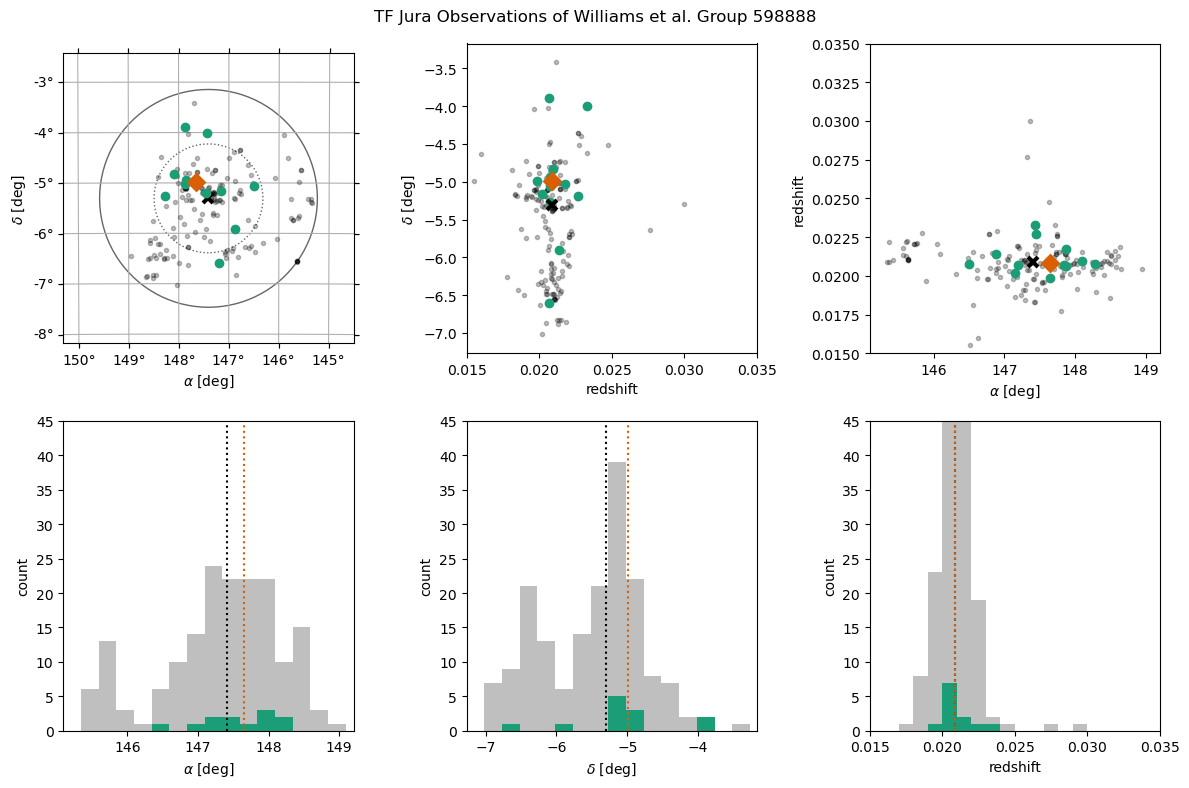

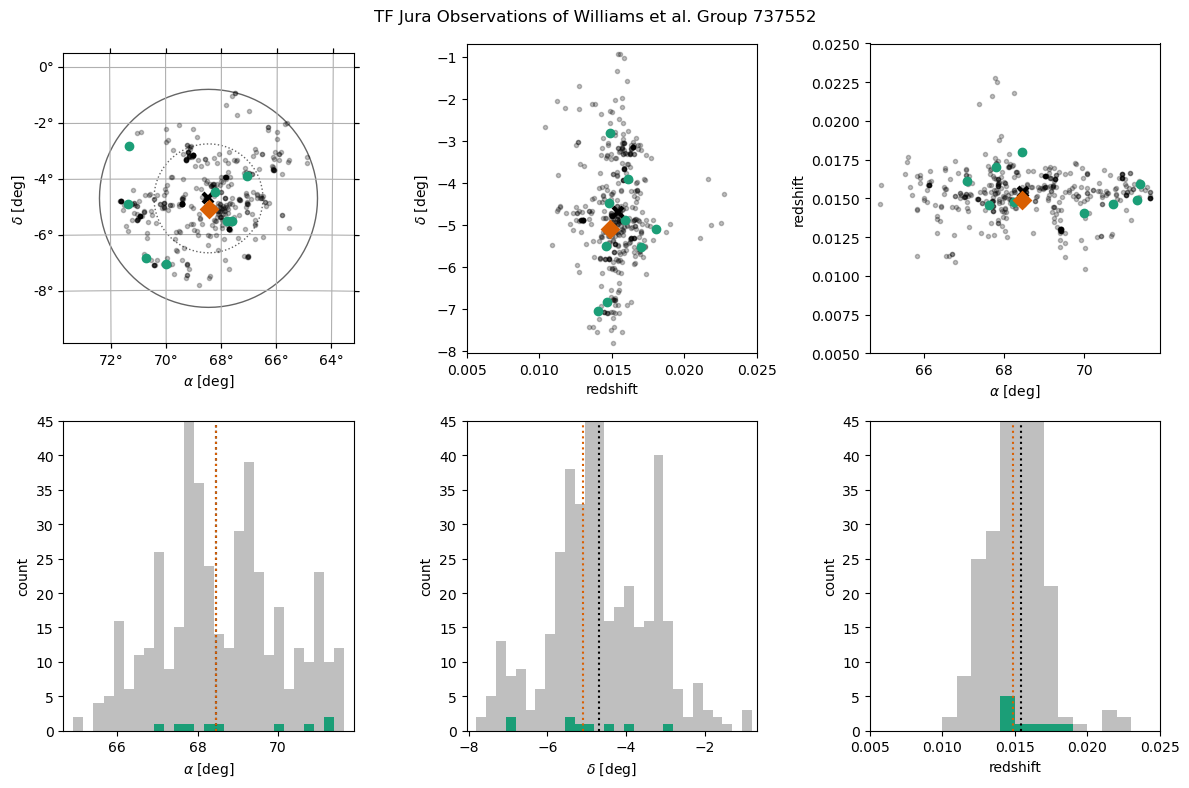

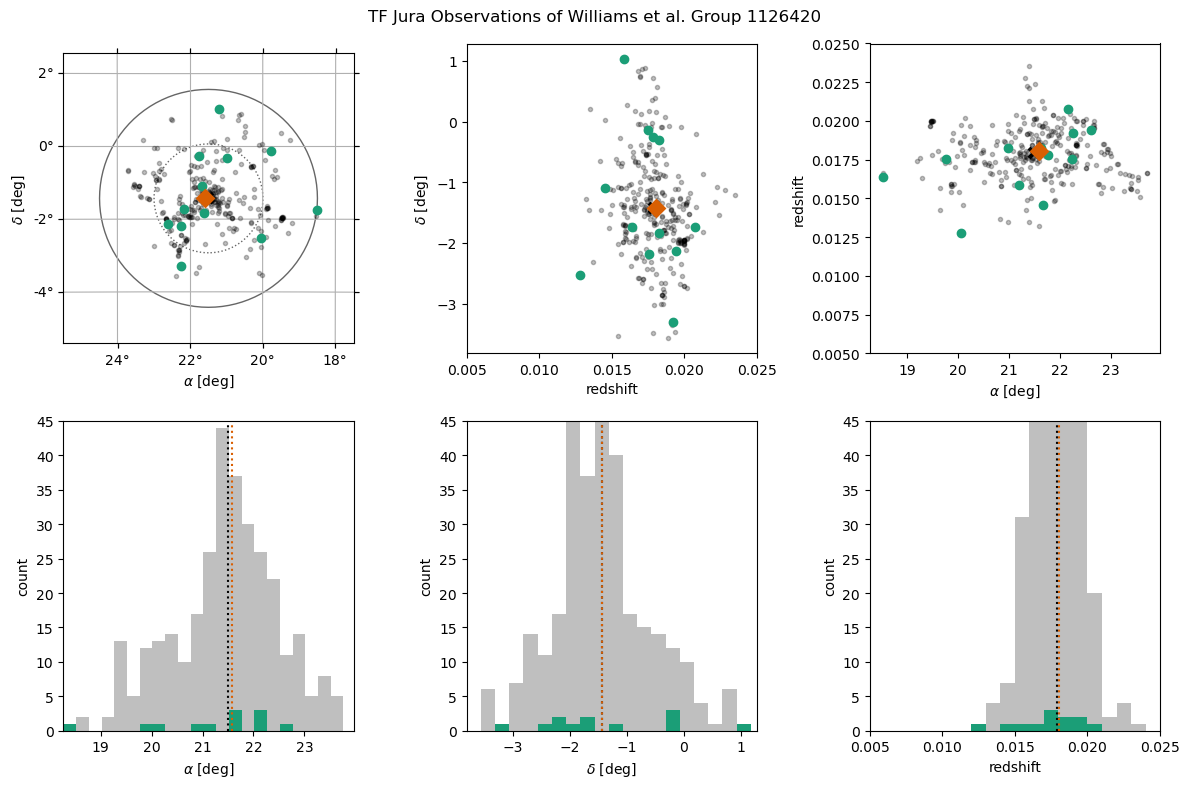

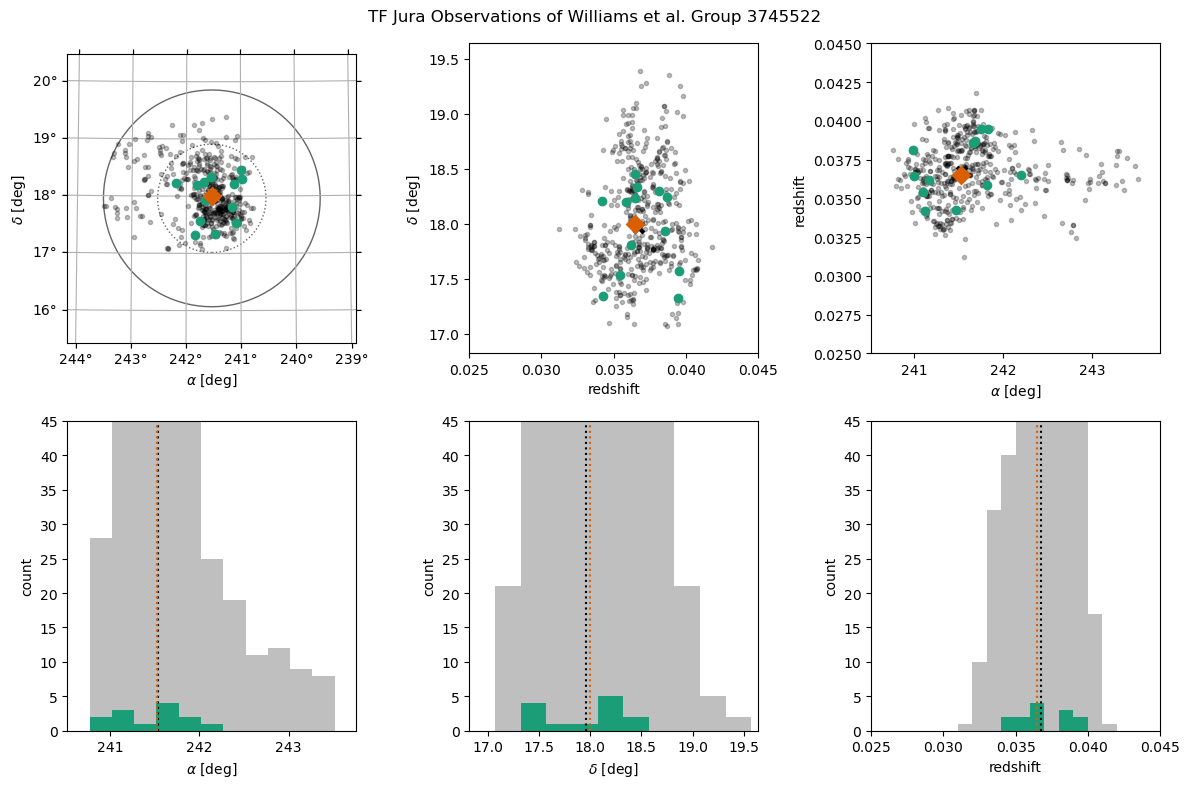

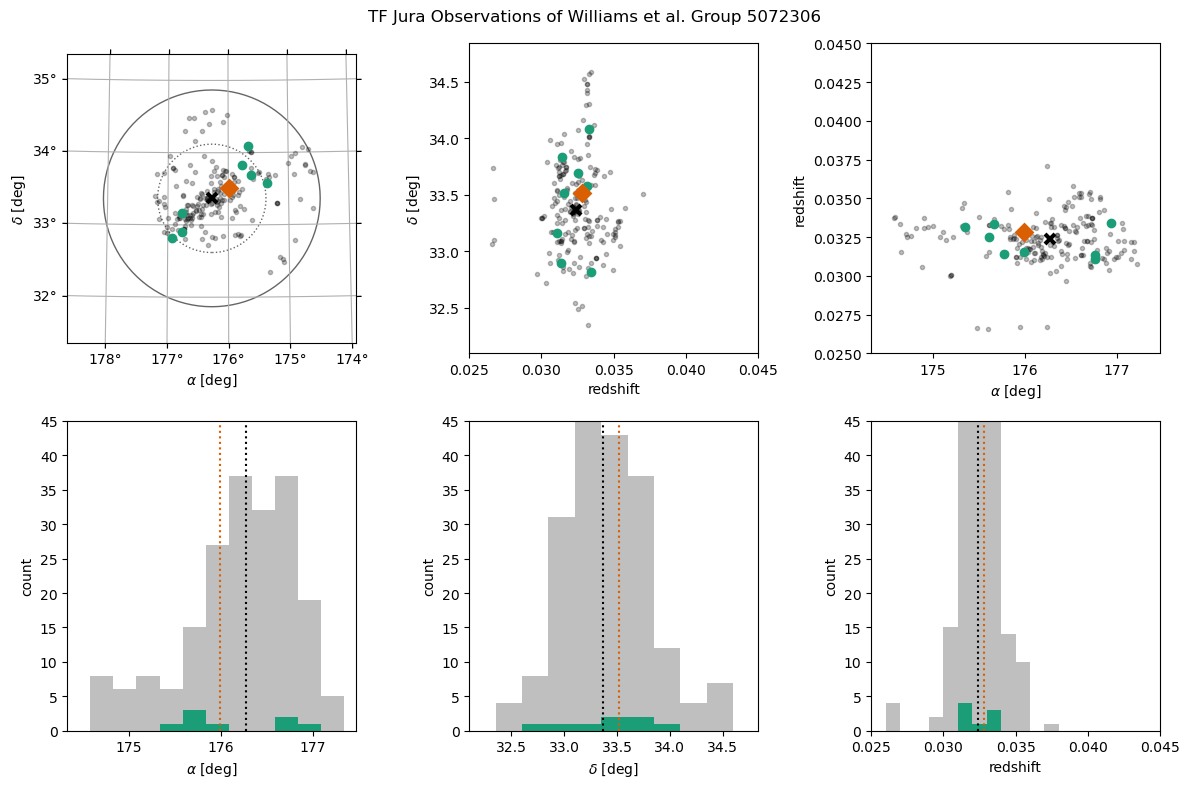

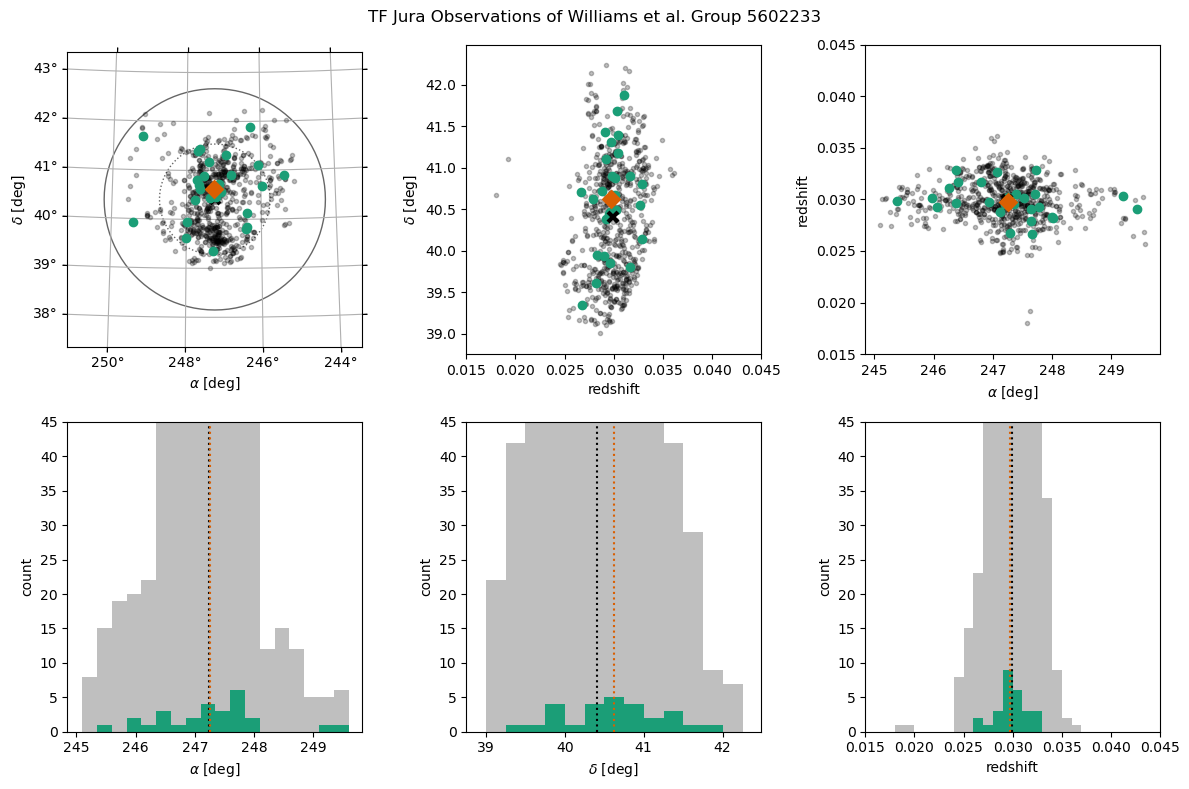

In [45]:
sga_coords_med = []
grp_coords_med = []
zs_sga_med = []
zs_grp_med = []
zs_sga = []
zs_grp = []

for groupid in sga_groups.keys():
    fig, sga_coord_med, grp_coord_med, z_sga, z_grp, z_sga_med, z_grp_med = plot_group_members(groups, sgatab_sel, groupid, VI_tab, sga_groups[groupid])
    grp_coords_med.append(grp_coord_med)
    sga_coords_med.append(sga_coord_med)
    zs_sga_med.append(z_sga_med)
    zs_grp_med.append(z_grp_med)
    zs_sga.append(z_sga)
    zs_grp.append(z_grp)

In [46]:
for i, (group_id, sga_ids) in enumerate(sga_groups.items()):
    print(f'{i+1:2d} {group_id:7d} {len(sga_ids):3d} galaxies')

 1  598888  12 galaxies
 2  737552   9 galaxies
 3 1126420  12 galaxies
 4 3745522  13 galaxies
 5 5072306   8 galaxies
 6 5602233  27 galaxies


# Apply Cluster Selection

We don't have information like $\angle(R_{2t})$, $v_\text{cluster}$, or $\sigma_P$ for this catalog, so the cluster selection is based off of RA, DEC, and $z$ as plotted above. We calculate the difference between the geometric median cluster center after cuts and the geometric median cluster center before cuts $(RA_\text{med}, DEC_\text{med})$, as well as the difference in median redshifts $z_\text{med}$. 

* $\Delta\theta$: the angular separation between the median position of the selected observations and the total observations.
* $\angle(R_{2t})$: the angular projection of the cluster second turnaround radius. Since this isn't a value in the Williams catalog, we approximate it using the distance from the median of the total observations to the furthest away point as $3R_{2t}$.
* $\Delta v = v_\text{cluster} - v_\text{SGA,median}$.
* $\sigma_P$: the velocity dispersion of the cluster.

A reasonable selection appears to be
1. $\Delta\theta / \angle(R_{2t}) < 1$
2. $\Delta v/ \sigma_P < 1$ 

In [47]:
group_ids = np.asarray(grp_ids)

med_separation = []
max_separation = []
norm_separation = []

for median in range(len(sga_coords_med)): 
    separation = sga_coords_med[median].separation(grp_coords_med[median]).to('rad')
    med_separation.append(separation)

for i in range(len(grp_coords_med)): 
    med = grp_coords_med[i]
    idx = np.in1d(sgatab_sel['IGRP'], group_ids[i])
    gal = SkyCoord(ra=sgatab_sel['RA_LEDA'][idx], dec=sgatab_sel['DEC_LEDA'][idx], unit='deg', frame='icrs')
    max_separation.append(np.max(gal.separation(med).to('rad')))

for n in range(len(med_separation)): 
    norm_separation.append(med_separation[n]/max_separation[n])

sep_cut_ids = []
sep_cut_ids_rej = []
for i in range(len(norm_separation)): 
    if norm_separation[i] < 1/3: 
        sep_cut_ids.append(group_ids[i])
    else: 
        sep_cut_ids_rej.append(group_ids[i])

sep_keep_group = sep_cut_ids
sep_reject_group = sep_cut_ids_rej
print('keep:', sep_keep_group)
print('drop:', sep_reject_group)

keep: [598888, 737552, 1126420, 3745522, 5072306, 5602233]
drop: []


In [48]:
group_ids = np.asarray(grp_ids) 
cz_grp_med = []
cz_sga_med = []
norm_v = []
delta_v = []
sigma_p = []
cz_grp = []
delv_sigp = []

# find ∆v 
for z in range(len(zs_grp_med)): 
    v = c_kms*zs_grp_med[z]
    cz_grp_med.append(v)
    
for z in range(len(zs_sga_med)): 
    v = c_kms*zs_sga_med[z]
    cz_sga_med.append(v)

for cz in range(len(cz_grp_med)): 
    dv = cz_grp_med[cz] - cz_sga_med[cz]
    delta_v.append(dv)

# find sigP
for z in range(len(zs_grp)): 
    v = c_kms*zs_grp[z]
    cz_grp.append(v)

for cz in range(len(cz_grp)): 
    sp = np.std(cz_grp[cz])
    sigma_p.append(sp)

for i in range(len(delta_v)): 
    ratio = delta_v[i]/sigma_p[i]
    delv_sigp.append(ratio)

v_cut_ids = []
v_cut_ids_rej = []

for i in range(len(delv_sigp)): 
    if np.abs(delv_sigp[i]) < 1: 
        v_cut_ids.append(group_ids[i])
    else: 
        v_cut_ids_rej.append(group_ids[i])

v_keep_group = v_cut_ids
v_reject_group = v_cut_ids_rej
print('keep:', v_keep_group)
print('drop:', v_reject_group)

keep: [598888, 737552, 1126420, 3745522, 5072306, 5602233]
drop: []


In [49]:
grp_ids = []
keep_group = []
reject_group = []
for i in group_ids: 
    if i in sep_keep_group and v_keep_group: 
        grp_ids.append(i)
        keep_group.append(i)
    else: 
        reject_group.append(i)
print(grp_ids)

[598888, 737552, 1126420, 3745522, 5072306, 5602233]


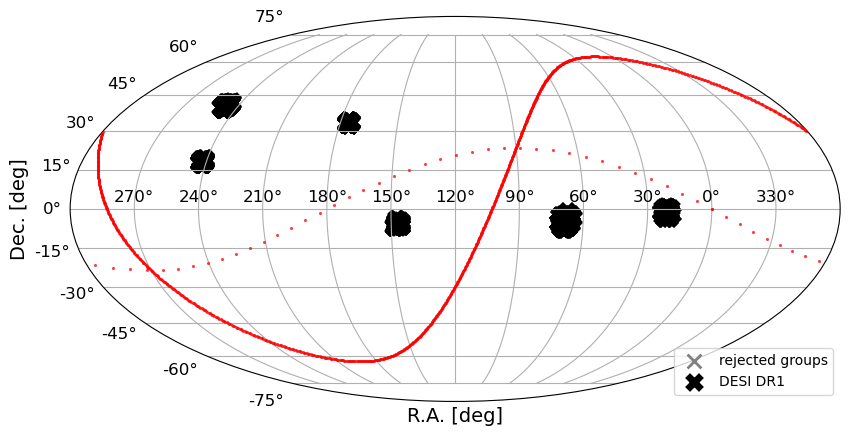

In [50]:
select = grp_ids
grp_ids = np.asarray(list(sga_groups.keys()))
good_idx = np.in1d(groups['IGRP'], keep_group)
bad_idx = np.in1d(groups['IGRP'], reject_group)
good_group_coords = SkyCoord(groups['RA'][good_idx], groups['DEC'][good_idx], unit='deg')
bad_group_coords = SkyCoord(groups['RA'][bad_idx], groups['DEC'][bad_idx], unit='deg')

ax = init_sky()

ax.scatter(ax.projection_ra(bad_group_coords.transform_to('icrs').ra.value), 
           ax.projection_dec(bad_group_coords.transform_to('icrs').dec.value), 
           marker='x', 
           s=100,
           linewidth=2,
           color='gray', 
           label='rejected groups')

ax.scatter(ax.projection_ra(good_group_coords.transform_to('icrs').ra.value), 
           ax.projection_dec(good_group_coords.transform_to('icrs').dec.value), 
           marker='x', 
           s=100,
           linewidth=5,
           color='black', 
           label='DESI DR1')

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.legend(loc='lower right')

plt.tick_params(axis='both', which='major', labelsize=12);

## Plot Galaxy Clusters that Failed the Selection

In [51]:
for group_id in sga_groups.keys():
    if group_id in reject_group:
        fig = plot_group_members(groups, sgatab_sel, group_id, VI_tab, sga_groups[group_id])
        # fig.savefig(f'../../Figures/Y3/TF_Y3_cluster_{cluster_id}_reject.png', dpi=150);

## Plot Galaxy Clusters that Passed the Selection

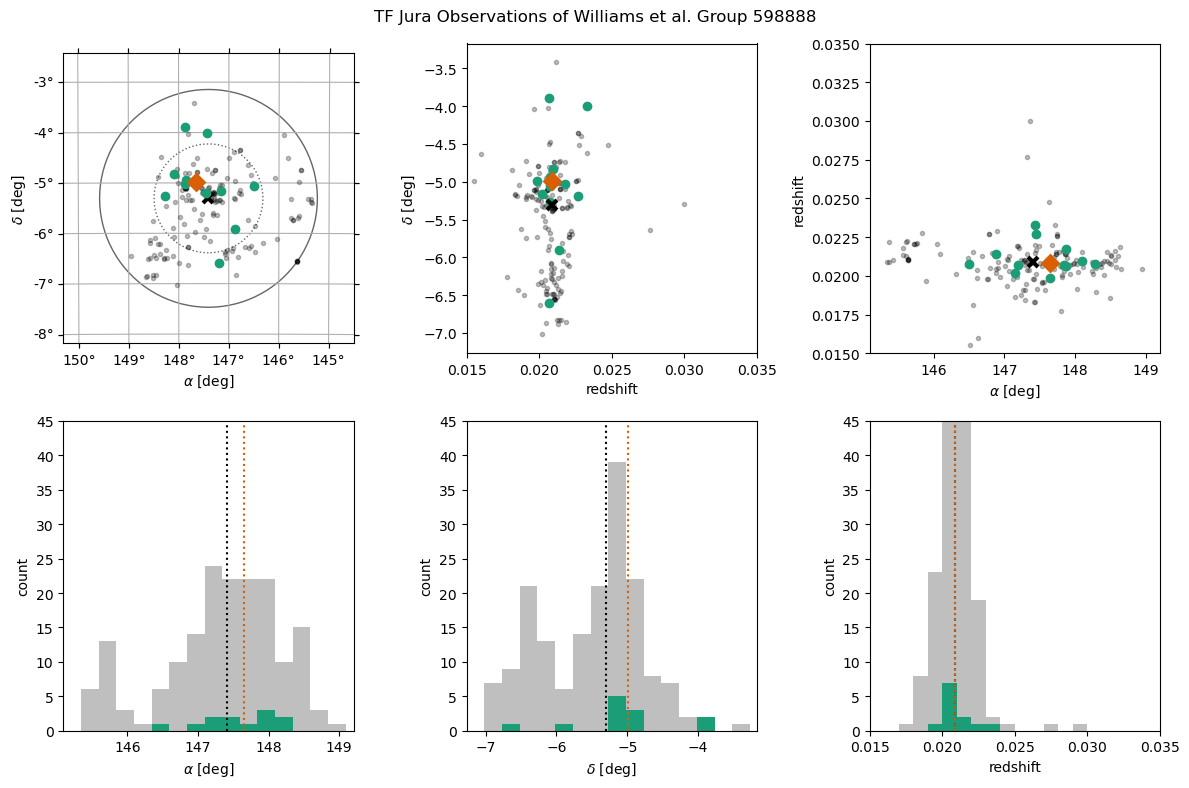

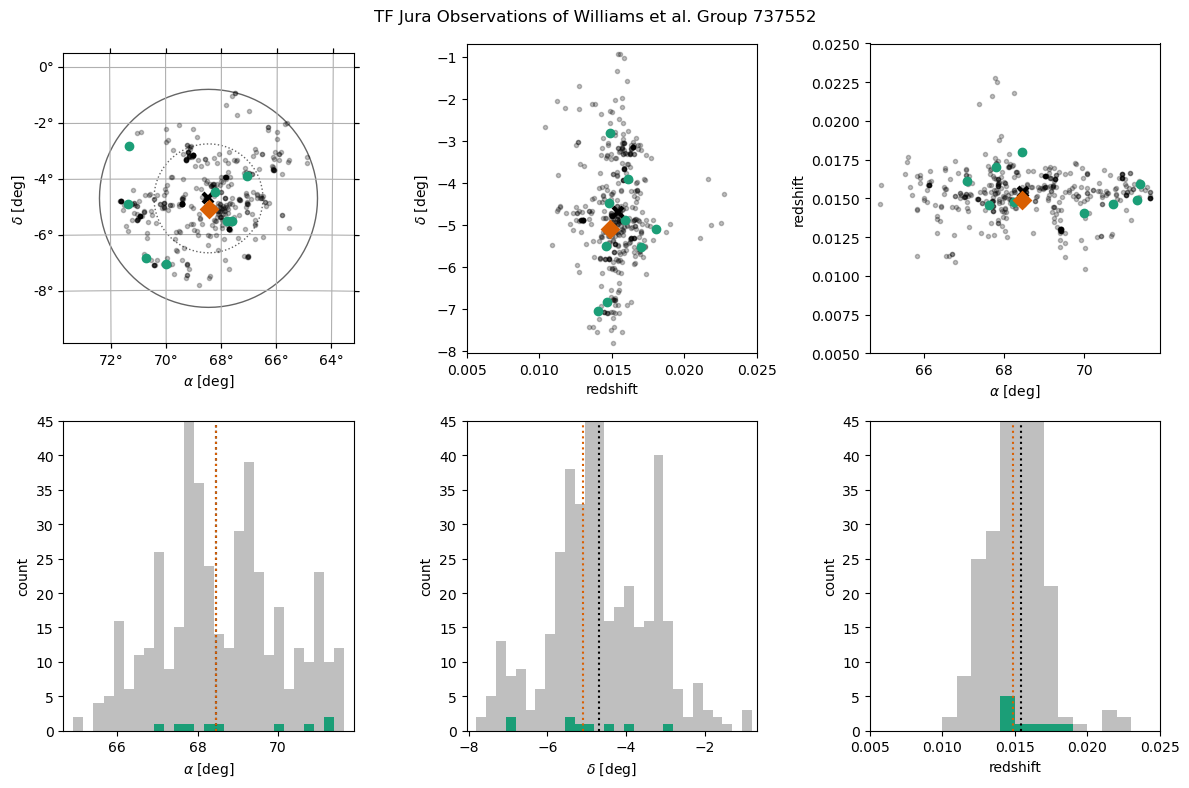

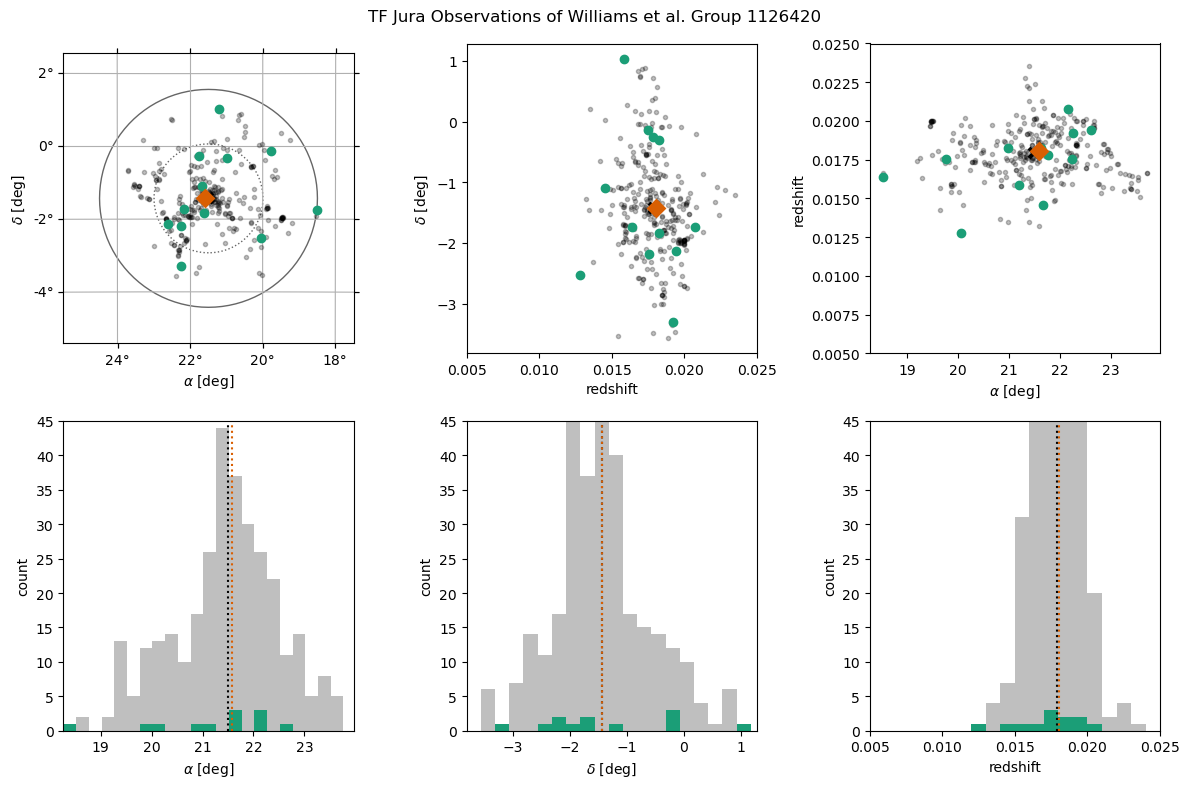

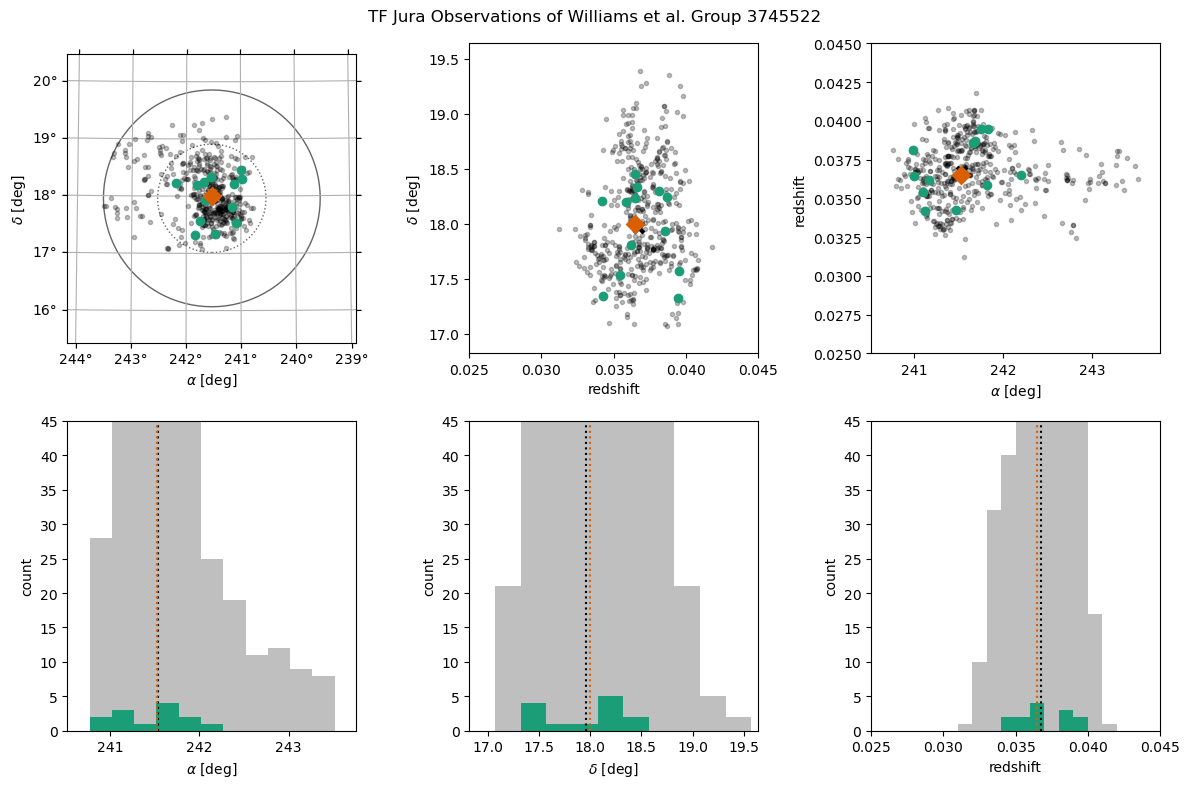

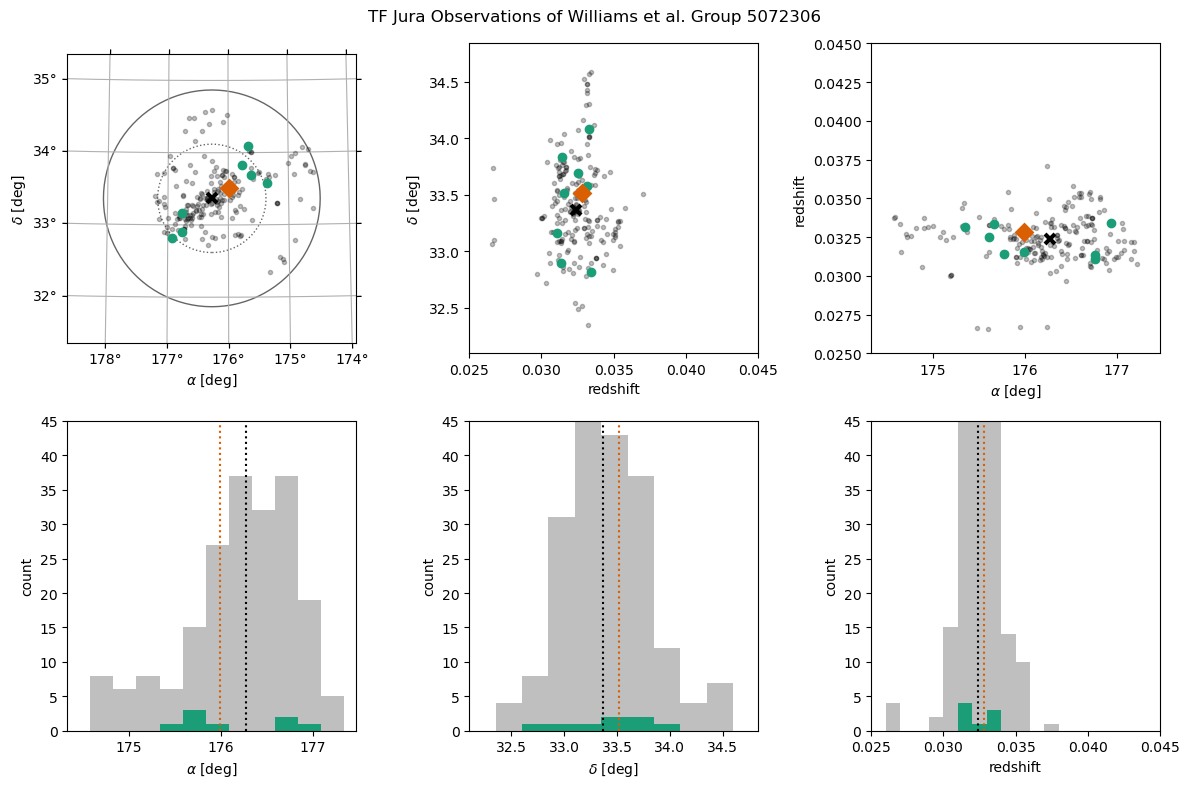

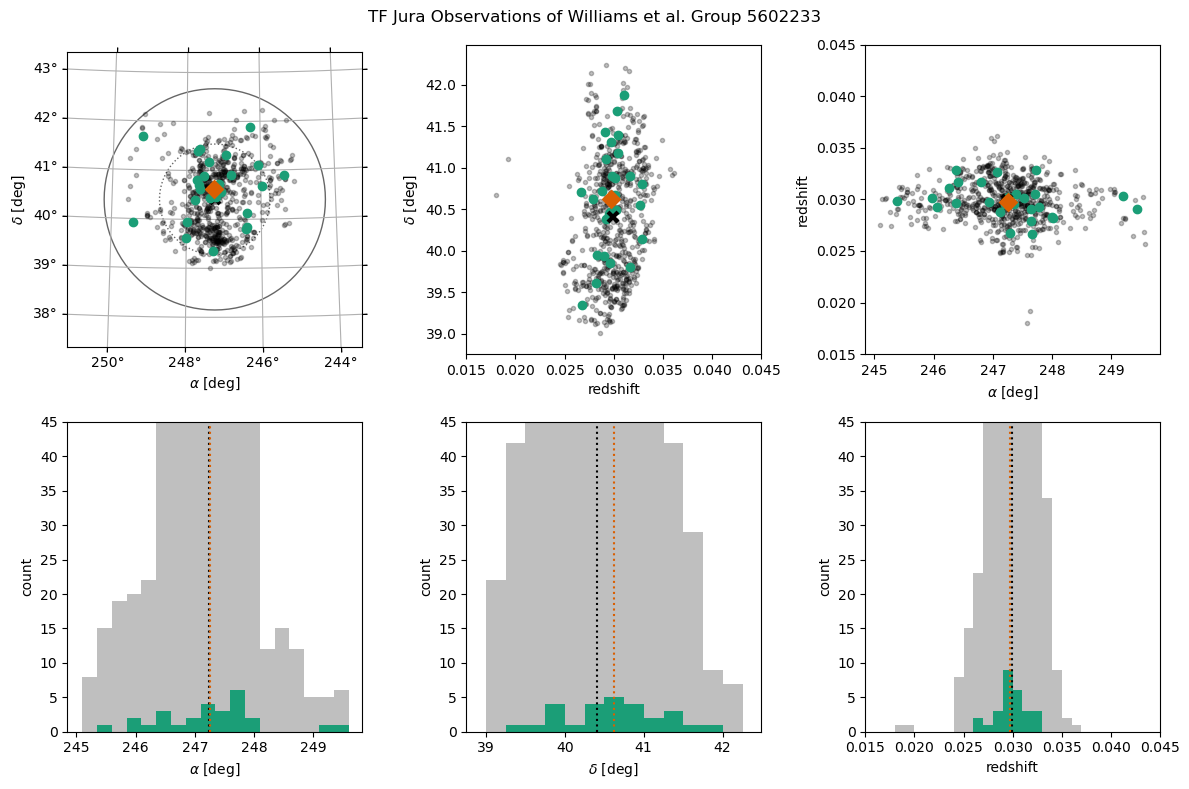

In [52]:
for group_id in sga_groups.keys():
    fig = plot_group_members(groups, sgatab_sel, group_id, VI_tab, sga_groups[group_id])
        # fig.savefig(f'../../Figures/Y3/TF_Y3_cluster_{cluster_id}_accept.png', dpi=150);

# Build the Calibration Table of SGA Galaxies in Clusters

In [53]:
caltab = None    # Table of selected clusters and SGA galaxies
rejtab = None    # Table of clusters failing the selection

for group_id, sga_ids in sga_groups.items():
    if group_id in keep_group:
        idx = np.in1d(VI_tab['SGA_ID'], sga_ids)
        grouptab = VI_tab[idx]
        grouptab['GROUP_ID'] = group_id
            
        caltab = grouptab if caltab is None else vstack([caltab, grouptab])
    
    else:
        idx = np.in1d(VI_tab['SGA_ID'], sga_ids)
        grouptab = VI_tab[idx]
        grouptab['GROUP_ID'] = group_id
        
        rejtab = grouptab if rejtab is None else vstack([rejtab, grouptab])
    
# caltab.write('SGA-2020_iron_Vrot_cluster_calib_z0p1.fits', overwrite=True)

if caltab is not None: 
    print(len(caltab))
elif caltab is None: 
    print('no groups')
    
caltab[['GROUP_ID', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_err']][:5]

81


GROUP_ID,SGA_ID,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,V_0p4R26,V_0p4R26_err
int64,float64,float64,float64,float64,float64
598888,407171.0,14.786642692312599,0.16266621882501722,146.97877203927243,11.588921624357054
598888,413420.0,16.759933324418963,0.1723652997361458,56.003742060950195,3.4828628536455493
598888,422578.0,16.02671065973118,0.1932559730968706,59.280911300888135,5.7503081799527855
598888,433697.0,14.908012967798859,0.12903167536037338,94.2122599024656,3.67230820198127
598888,438979.0,15.266560786627233,0.2347659872785143,102.43796078487507,4.366702448430471


In [54]:
# Save SGA IDs for each cluster that is part of the calibration (for Alex's Bayesian calibration)
for group in np.unique(caltab['GROUP_ID']):
    output_filename = 'output_' + str(group) + '.txt'
    # SGA_IDs_in_cluster = Table()
    # SGA_IDs_in_cluster['SGA_ID'] = c_4r_in_cluster[i]
    caltab[['SGA_ID']][caltab['GROUP_ID'] == group].write(output_filename, 
                                                              format='ascii.commented_header', 
                                                              overwrite=True)

In [55]:
if rejtab is None: 
    print('no rejects')
else:
    print(len(rejtab))
    rejtab[:5]

no rejects


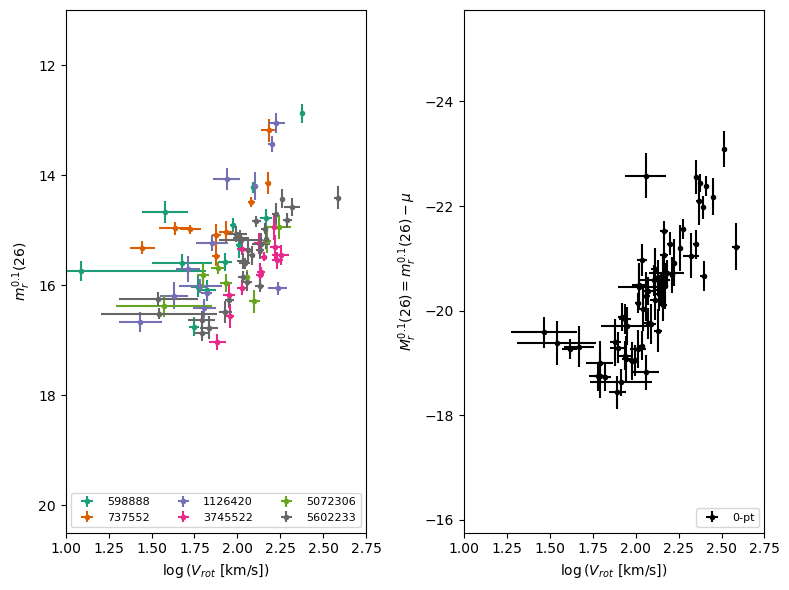

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)

logV0 = 0

ax = axes[0] 


#- Plot galaxies with failed group selections.
if rejtab is not None: 
    _group_ids = np.unique(rejtab['GROUP_ID'])
    markers = 'sDv^<>'
    for j, _group_id in enumerate(_group_ids):
        select_group = np.in1d(rejtab['GROUP_ID'], _group_id)
    
        #- Store independent variable for each group
        logv = np.log10(rejtab['V_0p4R26'][select_group].data) - logV0
        logv_err = 0.434*rejtab['V_0p4R26_err'][select_group].data / rejtab['V_0p4R26'][select_group].data
    
        #- Store dependent variable for each group
        mr26 = rejtab['R_MAG_SB26_CORR'][select_group].data
        mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_group].data
        
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 6], markersize=6, color='gray', alpha=0.3, label=f'{_group_id} (rej.)')

#- Plot galaxies and groups passing all selections.
_group_ids = np.unique(caltab['GROUP_ID'])

for _group_id in _group_ids:
    select_group = np.in1d(caltab['GROUP_ID'], _group_id)

    #- Store independent variable for each group
    logv = np.log10(caltab['V_0p4R26'][select_group].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_err'][select_group].data / caltab['V_0p4R26'][select_group].data

    #- Store dependent variable for each group
    mr26 = caltab['R_MAG_SB26_CORR'][select_group].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_group].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label=f'{_group_id}')

ax.set(xlim=[1, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[20.5, 11],
       ylabel=r'$m_r^{0.1} (26)$')
ax.legend(loc='lower right', fontsize=8, ncol = 3)

#- Plot the 0-pt calibrators
ax = axes[1]

logv = np.log10(zeroptab['V_0p4R26'].data) - logV0
logv_err = 0.434*zeroptab['V_0p4R26_err'].data / zeroptab['V_0p4R26'].data
mr26 = zeroptab['R_ABSMAG_SB26'].data
mr26_err = zeroptab['R_ABSMAG_SB26_err'].data

ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='k.', label='0-pt')
ax.set(xlim=[1, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[-15.75, -25.75],
       ylabel=r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$')
ax.legend(loc='lower right', fontsize=8, ncol = 3); 
# fig.savefig('../../Figures/Y1/TF_Y1_group_calibration_0pt_binaryMLupdated_20241203.png', dpi=150);

# Apply the Joint TFR Fit

In [57]:
#- Extract successful groups
_group_ids = np.unique(caltab['GROUP_ID'])
m = len(_group_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []

# logV0 = 2.25
logV0 = np.median(np.concatenate([np.log10(caltab['V_0p4R26']), 
                                  np.log10(zeroptab['V_0p4R26'])]))
print('logV0 =', logV0)

# Start with the zero-point calibrators
logV.append(np.log10(zeroptab['V_0p4R26']) - logV0)
logV_err.append(0.434*zeroptab['V_0p4R26_err'] / zeroptab['V_0p4R26'])
mag.append(zeroptab['R_ABSMAG_SB26'])
mag_err.append(zeroptab['R_ABSMAG_SB26_err'])

#- Loop over the SGA groups
for k, _group_id in enumerate(_group_ids):
    select_group = np.in1d(caltab['GROUP_ID'], _group_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_group]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_err'][select_group] / caltab['V_0p4R26'][select_group])
    mag.append(caltab['R_MAG_SB26_CORR'][select_group])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_group])

logV0 = 2.04747295444241


## Multiline Fit using HyperFit

In [58]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-40,0)] + m*[(-20, 20)]    # Bounds on b (intercepts: 0-pt + groups)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

     fun: -8220.848952654134
     jac: array([-0.00436557,  0.00090949,  0.00291038,  0.00145519,  0.00345608,
        0.00327418,  0.00090949,  0.00127329,  0.00109139])
 message: 'Optimization terminated successfully.'
    nfev: 12695
     nit: 92
 success: True
       x: array([ -6.35958515, -20.02716433,  14.62738594,  13.8704374 ,
        14.45760856,  16.08241324,  15.50521214,  15.7330152 ,
         0.56275184])
Ndim: 9 7


100%|██████████| 1000/1000 [00:11<00:00, 83.90it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [57.53193923 52.11604665 52.90366049 48.46056227 59.21301782 52.29352993
 51.22757339 47.11559171 55.10852428] / 2960.6508911394967


100%|██████████| 1000/1000 [00:11<00:00, 83.87it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [69.99275575 58.86148957 58.25772631 68.94361135 62.77931372 59.79922444
 66.52350818 58.97516231 64.28239781] / 3499.637787578014


100%|██████████| 1000/1000 [00:11<00:00, 83.92it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [85.5523247  72.56330584 65.67078056 72.68895279 66.06652252 67.38434491
 81.18469559 66.73632087 72.36611985] / 4277.616234969019


100%|██████████| 1000/1000 [00:11<00:00, 83.72it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [86.97900192 79.19855995 68.5697646  72.61739005 70.12344162 71.35238906
 89.59824199 74.15054094 73.1282536 ] / 4479.912099645409


100%|██████████| 1000/1000 [00:11<00:00, 83.71it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [82.54599158 81.80162016 71.73788875 73.86064408 77.25607395 77.51294373
 90.15805523 77.6941986  80.47539967] / 4507.902761669036


100%|██████████| 1000/1000 [00:12<00:00, 80.61it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [78.44947192 71.64979051 79.72952453 85.48283827 81.64354514 82.66945305
 91.36220809 77.33700919 87.46045319] / 4568.110404678029


100%|██████████| 1000/1000 [00:11<00:00, 83.54it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 80.17453156  74.98099873  88.52167106 101.14854528  79.19409074
  81.49053935  82.65267245  73.31046628  94.15433967] / 5057.427264190574


100%|██████████| 1000/1000 [00:11<00:00, 83.49it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 94.66309541  75.27804045  89.43774009 104.2058236   82.99159619
  77.21482117  81.64965626  75.35319558  92.77410194] / 5210.291179861928


100%|██████████| 1000/1000 [00:11<00:00, 83.53it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 94.17369181  78.84770805  92.41485625 108.32151424  92.69410105
  80.99826878  83.17795542  75.42236057  95.41785619] / 5416.075711982929


100%|██████████| 1000/1000 [00:12<00:00, 83.02it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 97.98108968  79.49927706  92.98595562 105.42064127  91.28393209
  77.57194351  79.16971673  81.35880297  95.71016441] / 5271.032063562186


100%|██████████| 1000/1000 [00:12<00:00, 83.13it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [103.03978926  81.74555543  98.2693667  105.9437772   91.2924328
  77.59784643  85.16779861  84.25133096  95.15887855] / 5297.188859756211


100%|██████████| 1000/1000 [00:12<00:00, 82.84it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [101.86284533  89.31407259 102.68530281 101.44316896  91.58851428
  80.73068143  83.30918843  86.42917066  95.12005569] / 5134.265140420273


100%|██████████| 1000/1000 [00:11<00:00, 83.69it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [104.61239889  89.04968469  97.16305362 104.82273023  90.97005388
  79.49508249  85.6545511   91.02449973  94.57803433] / 5241.136511255645


100%|██████████| 1000/1000 [00:11<00:00, 83.64it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [101.06280201  90.71891733  92.36257133  96.92678975  89.20571334
  80.43351577  85.8773466   92.8196032   96.19273585] / 5053.140100507257


100%|██████████| 1000/1000 [00:12<00:00, 81.54it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [96.00534541 93.07922227 91.11319521 97.85779826 93.17423465 83.31651506
 89.11574531 92.46607046 96.43346628] / 4892.889912996883


100%|██████████| 1000/1000 [00:12<00:00, 81.57it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 96.94122426  90.19497504  89.46813221 101.09469407  94.972947
  86.20794881  86.36881455  93.29877493  98.44229488] / 5054.734703497484


In [59]:
temp_outfile = open('cov_ab_jura_jointTFR_varyV0-perpdwarfs0_z0p1_bgsy3wip.pickle', 'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0), temp_outfile)
temp_outfile.close()

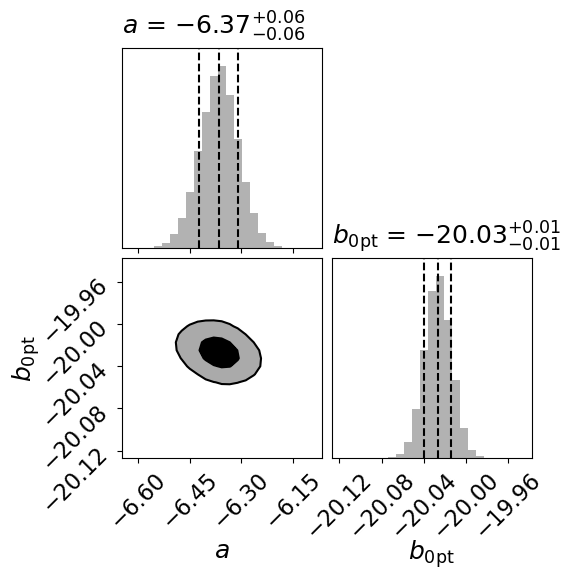

In [60]:
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$'] + [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples[0:2].T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y3/TF_Y3_group_calibration.png', dpi=150, facecolor='none');

### Plot the HyperFit Results

In [61]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
for k in range(1, m+2):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

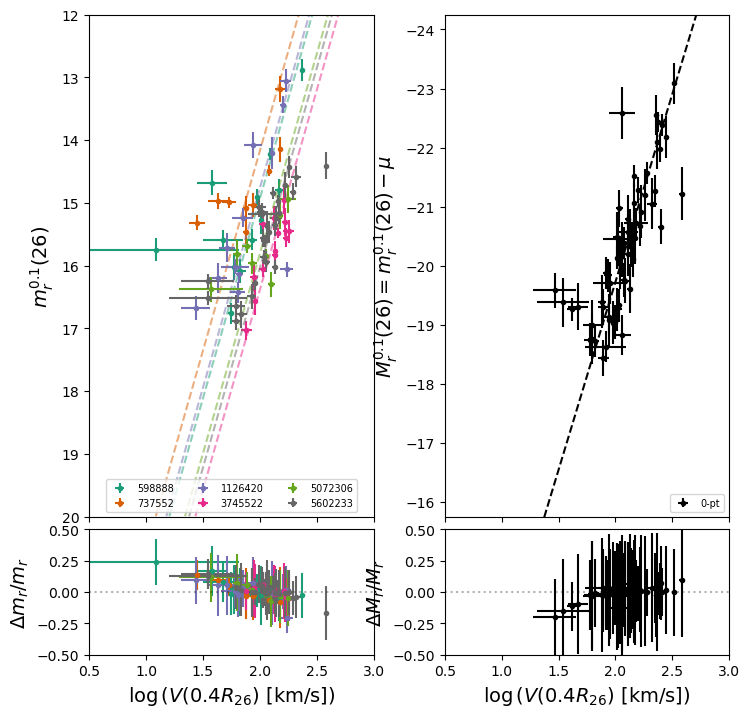

In [62]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1][1:]

#- Plot clusters
ax = axes[0,0]

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV[k+1] + logV0, y=mag[k+1], xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_group_ids[k]}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)#, label='fit')

ax.set(xlim=[.5, 3],
       ylim=[20, 12]
      )
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
ax.legend(loc='lower center', fontsize=7, ncol = 3);

#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='k.', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--')#, label='fit')
ax.set(xlim=[.5, 3],
       ylim=[-15.75, -24.25]
      )
ax.set_ylabel(r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$', fontsize=14)
ax.legend(loc='lower right', fontsize=7)

#- Plot residuals: clusters
ax = axes[1,0]

for k in range(m):
    logv_obs = logV[k+1]
    m_obs = mag[k+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_group_ids[k]}')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[.5, 3],
       ylim=[-0.5, 0.5])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)

#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[0], yerr=mag_err[0],
                     fmt='k.', label=f'0-pt')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[.5, 3],
       ylim=[-0.5, 0.5])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);
# fig.savefig('../../Figures/Y3/TF_Y3_cluster_calibration.png', dpi=150, facecolor='none')

-6.365497121350407


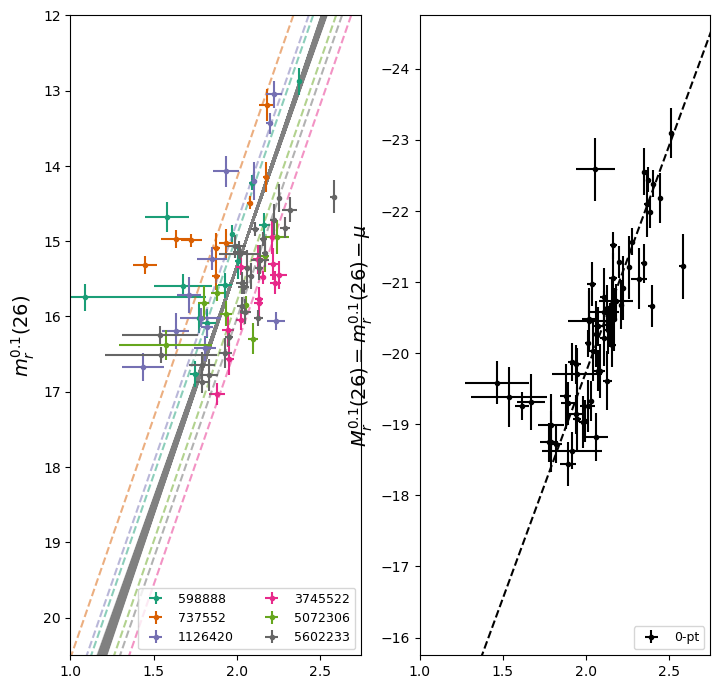

In [63]:
fig, axes = plt.subplots(1,2, figsize=(8, 8), sharex=True)#,gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1][1:]

#- Plot groups
ax = axes[0]

_logv = np.arange(0, 3, 0.1) - logV0

for (_a, _b0, _b1, _b2, _b3, _b4, _b5, _b6, _s) in tfr_mcmc_samples[:, ::100].T:
    ax.plot((_logv + logV0), _a*_logv + np.mean(b_), color='gray', alpha=0.1)
    
for k in range(m):
    eb = ax.errorbar(x=logV[k+1] + logV0, y=mag[k+1], xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_group_ids[k]}')
    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)#, label='fit')

ax.set(xlim=[1, 2.75],
       ylim=[20.5, 12]
      )
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
ax.legend(loc='lower right', fontsize=9, ncol=2);


#- Plot calibrators
ax = axes[1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='k.', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--')#, label='fit')
ax.set(xlim=[1, 2.75],
       ylim=[-15.75, -24.75]
      )
ax.set_ylabel(r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$', fontsize=14)
ax.legend(loc='lower right', fontsize=9, ncol=2)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);
# fig.savefig('../../Figures/Y1/TF_Y1_group_calibration_0pt_binaryMLupdated_z0p1_fit0_20241220.png', dpi=150, facecolor='none')
print(a_)

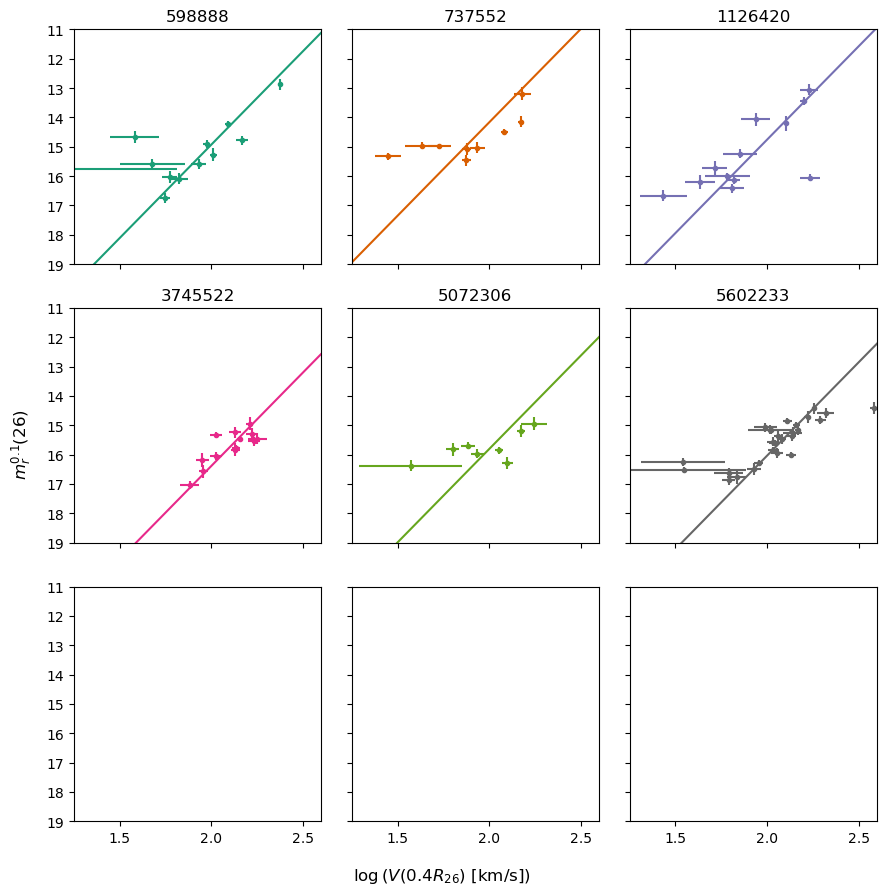

In [64]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(9,9), tight_layout=True)

color = iter(tfcolor)
for i in range(m):
    c = next(color)
    
    row = int(i/3)
    col = i%3
    
    eb = axs[row,col].errorbar(logV[i+1] + logV0, mag[i+1], xerr=logV_err[i+1], yerr=mag_err[i+1], fmt='.', color=c)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.25, 2.6], ylim=[19, 11], title=f'{_group_ids[i]}')
    
fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

### Does this calibration result in any dwarf galaxies?

Dwarf galaxies are defined as those below the line perpendicular to the calibration where $M_r > -17$.

#### Define the line perpendicular to the calibration

In [65]:
logV_n17 = (-17 - b0pt)/a_ + logV0
# b_perp = -17 + (logV_n17 - logV0)/a_
# b_perp

mr_n17 = a_*(logV_n17 - logV0) + b_
b_perp = mr_n17 + (logV_n17 - logV0)/a_

print(10**logV_n17, 'km/s')

37.320839652820915 km/s


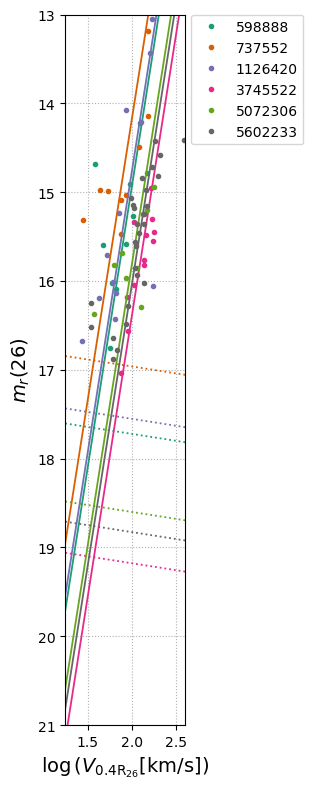

In [66]:
plt.figure(figsize=(4,8), tight_layout=True)

ax = plt.gca()

plt.grid(ls=':')

for k in range(m):
    eb = plt.plot(logV[k+1] + logV0, mag[k+1], '.', label=f'{_group_ids[k]}')
    plt.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), marker='None', ls='-', lw=1.3)
    plt.plot(_logv + logV0, -_logv/a_ + b_perp[k], color=eb[0].get_color(), marker='None', ls=':', lw=1.3)
    # plt.hlines(m_dwarf_groups[_group_ids[k]], 1.25, 2.75, colors=eb[0].get_color(), linestyles='dashed')
    
plt.xlabel(r'$\log{(V_\mathrm{0.4R_{26}} [\mathrm{km/s}])}$', fontsize=14)
plt.ylabel(r'$m_r (26)$', fontsize=14)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)

plt.xlim(1.25, 2.6)
plt.ylim(21, 13)

plt.gca().set_aspect('equal');

#### Filter out the dwarf galaxies

Those below the line
\begin{equation}
  m_r = -(\log(V(0.4R_{26})) - V_0)/a + b_{\rm group \perp}
\end{equation}

In [67]:
dwarfs = np.zeros(len(caltab), dtype=bool)

for i in range(m):
    # Retrieve this group's nest ID
    nestid = _group_ids[i]
    
    # Find all galaxies in this group
    group_gal_idx = caltab['GROUP_ID'] == nestid
    
    # Find which of these group galaxies are dwarfs
    group_dwarfs = (caltab['R_MAG_SB26_CORR'][group_gal_idx] - caltab['R_MAG_SB26_ERR_CORR'][group_gal_idx]) > (-(np.log10(caltab['V_0p4R26'][group_gal_idx]) - logV0)/a_ + b_perp[k])
    
    # Set the boolean correctly
    dwarfs[group_gal_idx] = group_dwarfs
    
caltab_bright = caltab[~dwarfs]

print(np.sum(dwarfs))

0
